In [1]:
%load_ext autoreload

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import AFAI_library as afai
import AFAI_library_torch as afai_cuda
import AFAI_parallelGPU as afai_parallel
import torch
from concurrent.futures import ThreadPoolExecutor, as_completed

In [3]:
%autoreload 2

In [4]:
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Current device: {torch.cuda.current_device()}")
print(f"Device name: {torch.cuda.get_device_name(0)}")

CUDA available: True
Current device: 0
Device name: NVIDIA A30


In [5]:
period = 2
hopping1 = - np.pi/(2)
hopping2 = - 3 * np.pi/(2)
hopping3 = - 5 * np.pi/(2)
np.set_printoptions(linewidth=300)

In [356]:
model_pest = afai_parallel.tb_floquet_pbc_cuda(period, 1, hopping1, num_y=2, device='cuda:1')
model_pest2 = afai_parallel.tb_floquet_pbc_cuda(period, 1, hopping2, num_y=2, device='cuda:1')
model_pest3 = afai_parallel.tb_floquet_pbc_cuda(period, 1, hopping3, num_y=2, device='cuda:1')

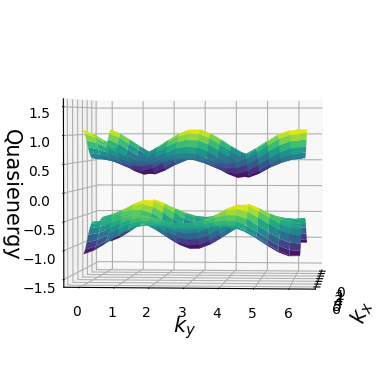

In [8]:
teo1 = model_pest.quasienergy_eigenstates(20,100,plot=True, pbc="xy")

In [9]:
print(teo1[0].shape)

torch.Size([21, 21, 2])


In [11]:
N_div = 6
teo = model_pest.eigen_grid(N_div,100,True)

In [12]:
delta = 1/N_div
delta_space = delta * torch.pi * 2
delta_t = delta * period
p0 = torch.tensor([0, 0, 0], dtype=torch.float64, device='cuda:0')
p = torch.tensor([delta_space, delta_space, delta_t], dtype=torch.float64, device='cuda:0')
ss = model_pest.S(p, teo[0], teo[1], N_div)
print(ss)

(tensor([-0.8279,  0.8279], device='cuda:0', dtype=torch.float64), tensor([[ 0.8112+0.0000j, -0.2924-0.5064j],
        [ 0.2924-0.5064j,  0.8112+0.0000j]], device='cuda:0',
       dtype=torch.complex128))


In [13]:
face = model_pest.face_F_hat(p, 1, teo[0], teo[1], N_div)
print(face)

tensor([ 0.0185, -0.0185], device='cuda:0', dtype=torch.float64)


In [15]:
for i in range(N_div-1):
    for j in range(N_div-1):
        for k in range(N_div-1):
            print(i,j,k)
            p = torch.tensor([delta_space * (i+1), delta_space * (j+1), delta_t * (k+1)], dtype=torch.float64, device='cuda:0')
            cube = model_pest.cube(p, teo[0], teo[1], N_div)
            print(cube)
            M = model_pest.determine_M(p, teo[0], teo[1], N_div, C_p=cube)
            print(M)

0 0 0
tensor([0., -0.], device='cuda:0', dtype=torch.float64)
tensor([0., 0.], device='cuda:0', dtype=torch.float64)
0 0 1
tensor([0., 0.], device='cuda:0', dtype=torch.float64)
tensor([0., 0.], device='cuda:0', dtype=torch.float64)
0 0 2
tensor([0., -0.], device='cuda:0', dtype=torch.float64)
tensor([0., 0.], device='cuda:0', dtype=torch.float64)
0 0 3
tensor([0., 0.], device='cuda:0', dtype=torch.float64)
tensor([0., 0.], device='cuda:0', dtype=torch.float64)
0 0 4
tensor([0., 0.], device='cuda:0', dtype=torch.float64)
tensor([0., 0.], device='cuda:0', dtype=torch.float64)
0 1 0
tensor([0., -0.], device='cuda:0', dtype=torch.float64)
tensor([0., 0.], device='cuda:0', dtype=torch.float64)
0 1 1
tensor([0., 0.], device='cuda:0', dtype=torch.float64)
tensor([0., 0.], device='cuda:0', dtype=torch.float64)
0 1 2
tensor([-0., 0.], device='cuda:0', dtype=torch.float64)
tensor([0., 0.], device='cuda:0', dtype=torch.float64)
0 1 3
tensor([0., 0.], device='cuda:0', dtype=torch.float64)
tensor(

In [22]:
C_p = torch.tensor([0, -1, 1, 0])

In [23]:
M_p = torch.zeros_like(C_p)
print(M_p)
non_zero_indices = torch.nonzero(C_p).squeeze()
print(non_zero_indices)
if len(non_zero_indices) == 2:
    print(True)
    nu, nu_prime = non_zero_indices
    print(nu, nu_prime)

tensor([0, 0, 0, 0])
tensor([1, 2])
True
tensor(1) tensor(2)


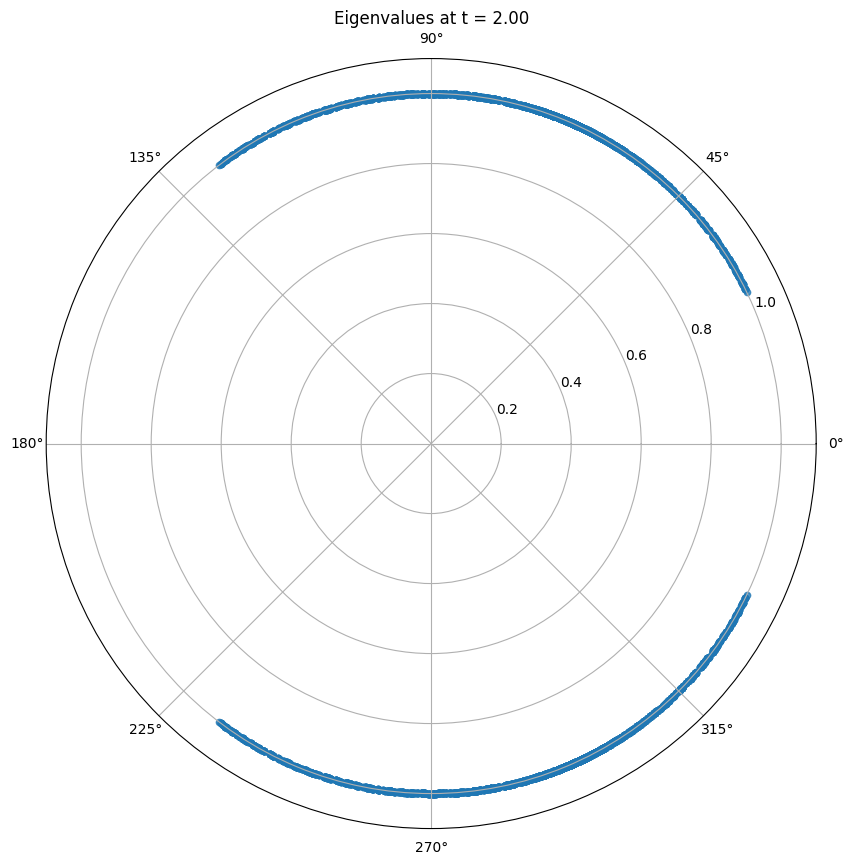

In [21]:
x = model_pest.eigen_grid(80, 100, plot=True, save_path="xx.mp4")

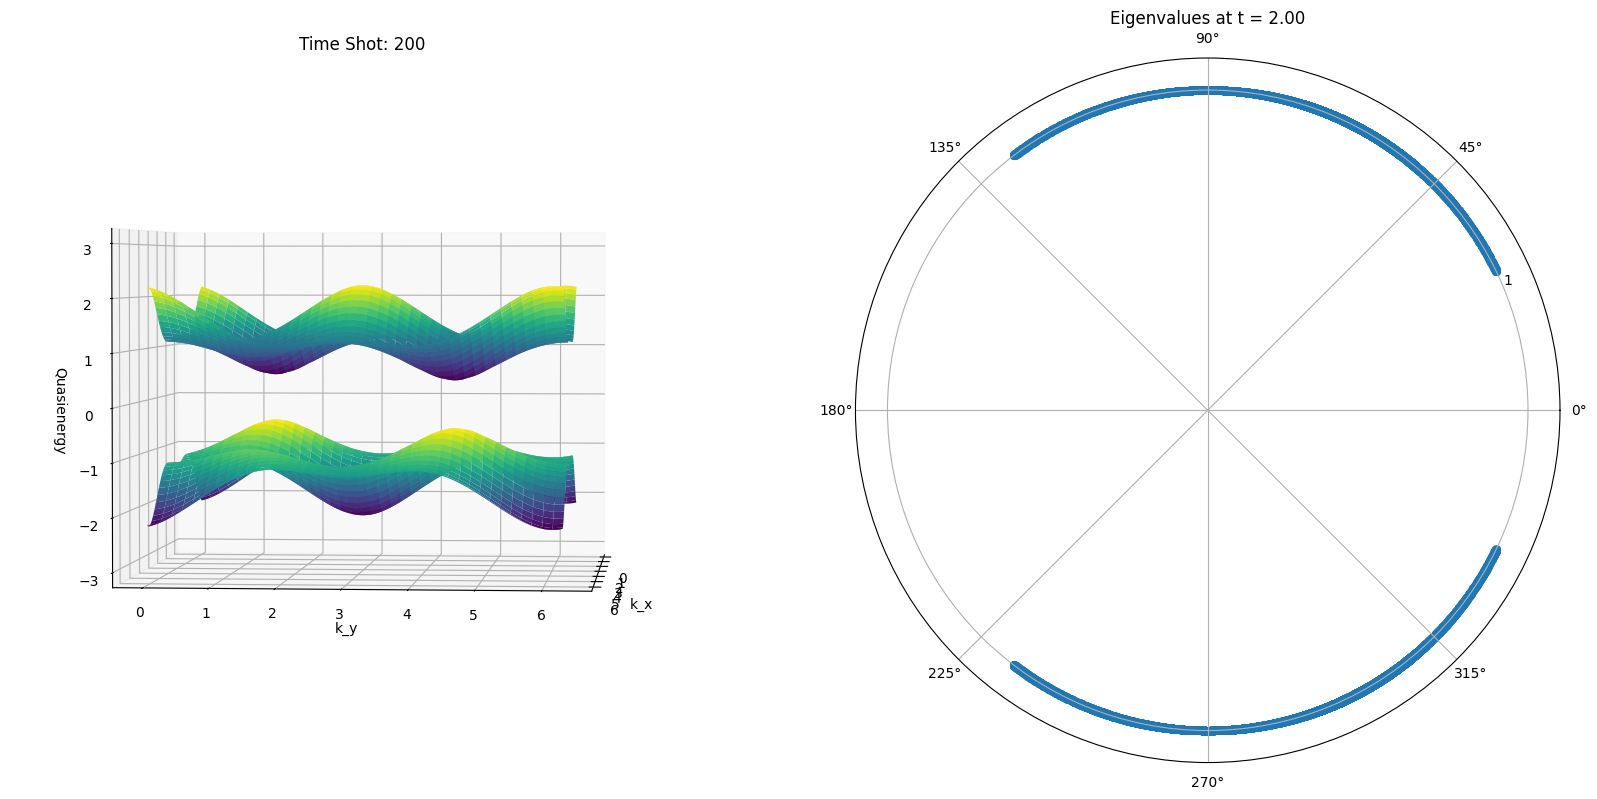

In [27]:
x = model_pest.animate_combined_spectra(200, 1000, filename="xxx.mp4")

In [ ]:
x = model_pest2.animate_combined_spectra(200, 1000, filename="xxx.mp4")

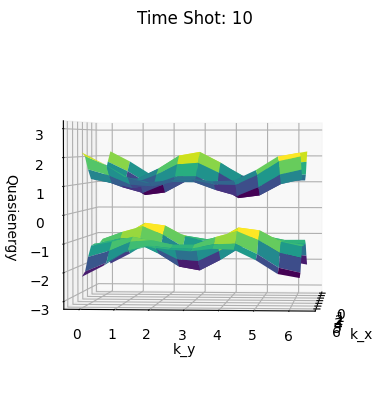

In [14]:
model_pest.animate_quasienergy_spectra(10, 100, filename="quasienergy_minimum_ani_10.mp4")

In [11]:
w3 = model_pest.w3(80, 100)

In [12]:
print(w3)

tensor(-2., device='cuda:0', dtype=torch.float64)


In [33]:
wind3 = model_pest.winding3(20, 100, branch_cut_angle=0)

In [34]:
print(wind3)

tensor(-0.2245, device='cuda:0', dtype=torch.float64)


In [31]:
wind3 = model_pest.winding3(20, 100, branch_cut_angle=-torch.pi)

In [32]:
print(wind3)

tensor(-2., device='cuda:0', dtype=torch.float64)


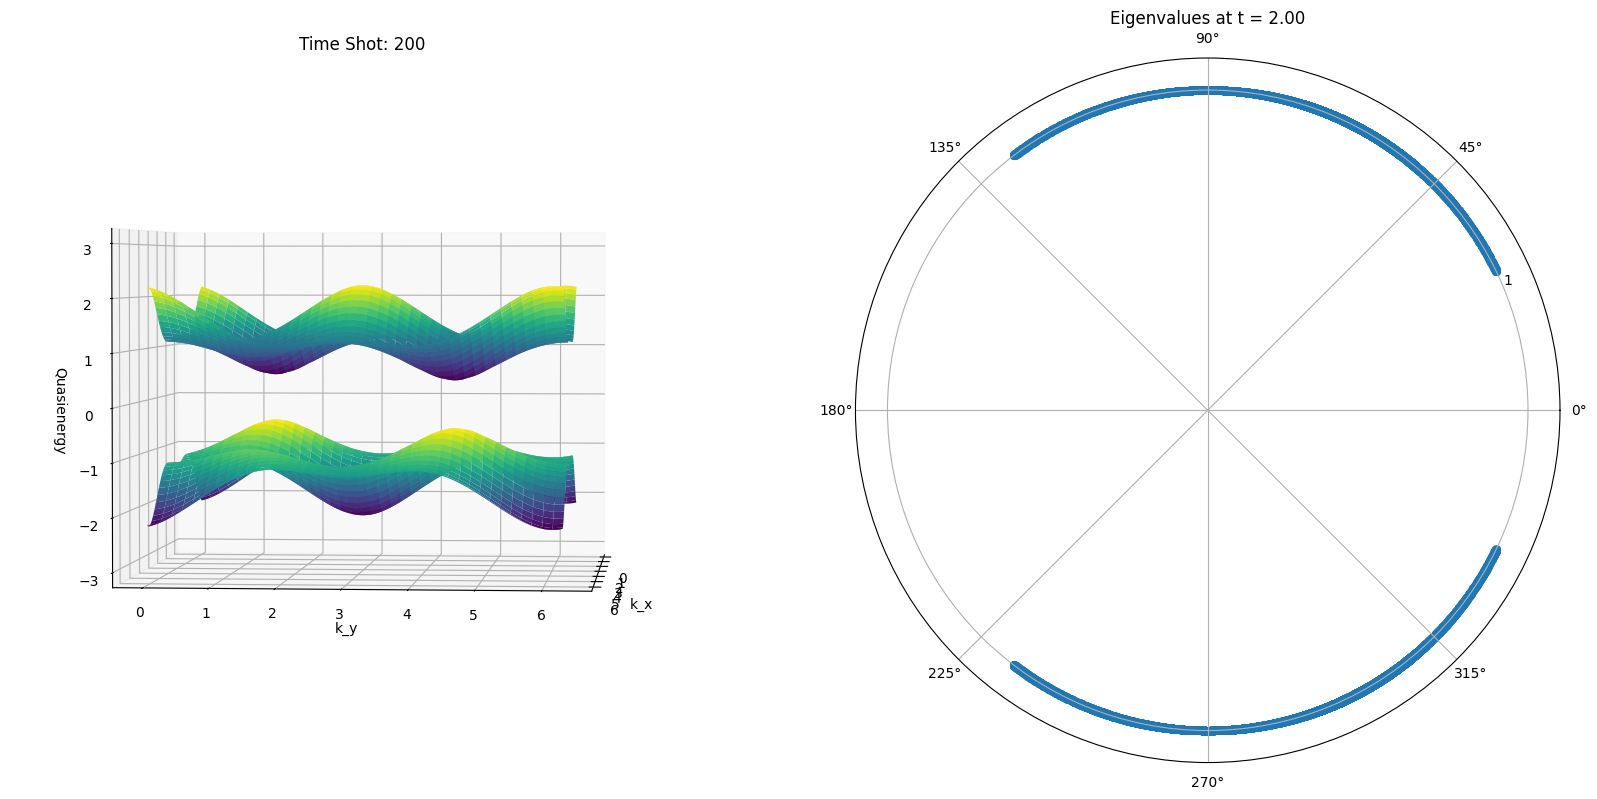

In [12]:
xxx = model_pest2.animate_combined_spectra(200, 1000, filename="3pi_2period.mp4")

In [45]:
wind3_2 = model_pest2.winding3(20, 100, 0)

In [46]:
print(wind3_2)

tensor(-0.2245, device='cuda:0', dtype=torch.float64)


In [47]:
wind3_3 = model_pest2.winding3(20, 100, -torch.pi)

In [48]:
print(wind3_3)

tensor(-2., device='cuda:0', dtype=torch.float64)


In [ ]:
xxxx = model_pest3.animate_combined_spectra(200, 1000, filename="5pi_2period.mp4")

In [49]:
wind3_2 = model_pest3.winding3(20, 100, 0)

In [50]:
print(wind3_2)

tensor(-2.0161, device='cuda:0', dtype=torch.float64)


In [51]:
wind3_3 = model_pest3.winding3(20, 100, -torch.pi)

In [52]:
print(wind3_3)

tensor(-2., device='cuda:0', dtype=torch.float64)


In [15]:
w3 = model_pest2.w3(5, steps_per_segment=100)
print(w3)

tensor(-1., device='cuda:0', dtype=torch.float64)


In [17]:
eigenvaluer, eigenvalue, eigenvector = model_pest2.eigen_grid(10, steps_per_segment=100)

In [19]:
print(eigenvaluer.shape)

torch.Size([11, 11, 11, 2])


In [20]:
m = model_pest2.determine_m(10, 10, 10, eigenvaluer, eigenvector)

tensor([[-0., -0.],
        [-0., -0.],
        [-0., -0.]], device='cuda:0', dtype=torch.float64)


In [21]:
m = model_pest2.determine_m(1, 1, 1, eigenvaluer, eigenvector)

tensor([[-0., -0.],
        [-0., -0.],
        [-0., -0.]], device='cuda:0', dtype=torch.float64)


In [57]:
wind3 = model_pest2.w3(10, 100)
print(wind3)

($i_1, i_2, i_3$) 1 1 1
vertices for face tensor([[[1, 1, 1],
         [1, 2, 1],
         [1, 2, 2],
         [1, 1, 2]],

        [[1, 1, 1],
         [1, 1, 2],
         [2, 1, 2],
         [2, 1, 1]],

        [[1, 1, 1],
         [2, 1, 1],
         [2, 2, 1],
         [1, 2, 1]]], device='cuda:1')
vertices for face tensor([[[2, 1, 1],
         [2, 2, 1],
         [2, 2, 2],
         [2, 1, 2]],

        [[2, 1, 1],
         [2, 1, 2],
         [3, 1, 2],
         [3, 1, 1]],

        [[2, 1, 1],
         [3, 1, 1],
         [3, 2, 1],
         [2, 2, 1]]], device='cuda:1')
vertices for face tensor([[[1, 2, 1],
         [1, 3, 1],
         [1, 3, 2],
         [1, 2, 2]],

        [[1, 2, 1],
         [1, 2, 2],
         [2, 2, 2],
         [2, 2, 1]],

        [[1, 2, 1],
         [2, 2, 1],
         [2, 3, 1],
         [1, 3, 1]]], device='cuda:1')
vertices for face tensor([[[1, 1, 2],
         [1, 2, 2],
         [1, 2, 3],
         [1, 1, 3]],

        [[1, 1, 2],
         [1, 

In [42]:
wind3_3 = model_pest3.w3(6, 100)
print(wind3)

($i_1, i_2, i_3$) 1 1 1
vertices for face tensor([[[1, 1, 1],
         [1, 2, 1],
         [1, 2, 2],
         [1, 1, 2]],

        [[1, 1, 1],
         [1, 1, 2],
         [2, 1, 2],
         [2, 1, 1]],

        [[1, 1, 1],
         [2, 1, 1],
         [2, 2, 1],
         [1, 2, 1]]], device='cuda:1')
vertices for face tensor([[[2, 1, 1],
         [2, 2, 1],
         [2, 2, 2],
         [2, 1, 2]],

        [[2, 1, 1],
         [2, 1, 2],
         [3, 1, 2],
         [3, 1, 1]],

        [[2, 1, 1],
         [3, 1, 1],
         [3, 2, 1],
         [2, 2, 1]]], device='cuda:1')
vertices for face tensor([[[1, 2, 1],
         [1, 3, 1],
         [1, 3, 2],
         [1, 2, 2]],

        [[1, 2, 1],
         [1, 2, 2],
         [2, 2, 2],
         [2, 2, 1]],

        [[1, 2, 1],
         [2, 2, 1],
         [2, 3, 1],
         [1, 3, 1]]], device='cuda:1')
vertices for face tensor([[[1, 1, 2],
         [1, 2, 2],
         [1, 2, 3],
         [1, 1, 3]],

        [[1, 1, 2],
         [1, 

In [31]:
w3_correct = model_pest2.winding3(6, 100, branch_cut_angle=0)
print(w3_correct)

($i_1, i_2, i_3$) 1 1 1
tensor([[[1, 1, 1],
         [1, 2, 1],
         [1, 2, 2],
         [1, 1, 2]],

        [[1, 1, 1],
         [1, 1, 2],
         [2, 1, 2],
         [2, 1, 1]],

        [[1, 1, 1],
         [2, 1, 1],
         [2, 2, 1],
         [1, 2, 1]]], device='cuda:1')
tensor([[[2, 1, 1],
         [2, 2, 1],
         [2, 2, 2],
         [2, 1, 2]],

        [[2, 1, 1],
         [2, 1, 2],
         [3, 1, 2],
         [3, 1, 1]],

        [[2, 1, 1],
         [3, 1, 1],
         [3, 2, 1],
         [2, 2, 1]]], device='cuda:1')
tensor([[[1, 2, 1],
         [1, 3, 1],
         [1, 3, 2],
         [1, 2, 2]],

        [[1, 2, 1],
         [1, 2, 2],
         [2, 2, 2],
         [2, 2, 1]],

        [[1, 2, 1],
         [2, 2, 1],
         [2, 3, 1],
         [1, 3, 1]]], device='cuda:1')
tensor([[[1, 1, 2],
         [1, 2, 2],
         [1, 2, 3],
         [1, 1, 3]],

        [[1, 1, 2],
         [1, 1, 3],
         [2, 1, 3],
         [2, 1, 2]],

        [[1, 1, 2],
   

In [43]:
w3_correct_3 = model_pest3.winding3(6, 100, 0)

($i_1, i_2, i_3$) 1 1 1
vertices for face tensor([[[1, 1, 1],
         [1, 2, 1],
         [1, 2, 2],
         [1, 1, 2]],

        [[1, 1, 1],
         [1, 1, 2],
         [2, 1, 2],
         [2, 1, 1]],

        [[1, 1, 1],
         [2, 1, 1],
         [2, 2, 1],
         [1, 2, 1]]], device='cuda:1')
vertices for face tensor([[[2, 1, 1],
         [2, 2, 1],
         [2, 2, 2],
         [2, 1, 2]],

        [[2, 1, 1],
         [2, 1, 2],
         [3, 1, 2],
         [3, 1, 1]],

        [[2, 1, 1],
         [3, 1, 1],
         [3, 2, 1],
         [2, 2, 1]]], device='cuda:1')
vertices for face tensor([[[1, 2, 1],
         [1, 3, 1],
         [1, 3, 2],
         [1, 2, 2]],

        [[1, 2, 1],
         [1, 2, 2],
         [2, 2, 2],
         [2, 2, 1]],

        [[1, 2, 1],
         [2, 2, 1],
         [2, 3, 1],
         [1, 3, 1]]], device='cuda:1')
vertices for face tensor([[[1, 1, 2],
         [1, 2, 2],
         [1, 2, 3],
         [1, 1, 3]],

        [[1, 1, 2],
         [1, 

In [44]:
print(w3_correct_3)

tensor(2.0000, device='cuda:1', dtype=torch.float64)


In [45]:
branch = torch.pi - 0.14

In [46]:
w3_correct = model_pest3.winding3(6, 100, branch_cut_angle=branch)
print(w3_correct)

($i_1, i_2, i_3$) 1 1 1
vertices for face tensor([[[1, 1, 1],
         [1, 2, 1],
         [1, 2, 2],
         [1, 1, 2]],

        [[1, 1, 1],
         [1, 1, 2],
         [2, 1, 2],
         [2, 1, 1]],

        [[1, 1, 1],
         [2, 1, 1],
         [2, 2, 1],
         [1, 2, 1]]], device='cuda:1')
vertices for face tensor([[[2, 1, 1],
         [2, 2, 1],
         [2, 2, 2],
         [2, 1, 2]],

        [[2, 1, 1],
         [2, 1, 2],
         [3, 1, 2],
         [3, 1, 1]],

        [[2, 1, 1],
         [3, 1, 1],
         [3, 2, 1],
         [2, 2, 1]]], device='cuda:1')
vertices for face tensor([[[1, 2, 1],
         [1, 3, 1],
         [1, 3, 2],
         [1, 2, 2]],

        [[1, 2, 1],
         [1, 2, 2],
         [2, 2, 2],
         [2, 2, 1]],

        [[1, 2, 1],
         [2, 2, 1],
         [2, 3, 1],
         [1, 3, 1]]], device='cuda:1')
vertices for face tensor([[[1, 1, 2],
         [1, 2, 2],
         [1, 2, 3],
         [1, 1, 3]],

        [[1, 1, 2],
         [1, 

In [47]:
w3_1 = model_pest.w3(6, 100)
print(w3_1)

($i_1, i_2, i_3$) 1 1 1
vertices for face tensor([[[1, 1, 1],
         [1, 2, 1],
         [1, 2, 2],
         [1, 1, 2]],

        [[1, 1, 1],
         [1, 1, 2],
         [2, 1, 2],
         [2, 1, 1]],

        [[1, 1, 1],
         [2, 1, 1],
         [2, 2, 1],
         [1, 2, 1]]], device='cuda:1')
vertices for face tensor([[[2, 1, 1],
         [2, 2, 1],
         [2, 2, 2],
         [2, 1, 2]],

        [[2, 1, 1],
         [2, 1, 2],
         [3, 1, 2],
         [3, 1, 1]],

        [[2, 1, 1],
         [3, 1, 1],
         [3, 2, 1],
         [2, 2, 1]]], device='cuda:1')
vertices for face tensor([[[1, 2, 1],
         [1, 3, 1],
         [1, 3, 2],
         [1, 2, 2]],

        [[1, 2, 1],
         [1, 2, 2],
         [2, 2, 2],
         [2, 2, 1]],

        [[1, 2, 1],
         [2, 2, 1],
         [2, 3, 1],
         [1, 3, 1]]], device='cuda:1')
vertices for face tensor([[[1, 1, 2],
         [1, 2, 2],
         [1, 2, 3],
         [1, 1, 3]],

        [[1, 1, 2],
         [1, 

In [48]:
wind3_1 = model_pest.winding3(6, 100, 0)
print(wind3_1)

($i_1, i_2, i_3$) 1 1 1
vertices for face tensor([[[1, 1, 1],
         [1, 2, 1],
         [1, 2, 2],
         [1, 1, 2]],

        [[1, 1, 1],
         [1, 1, 2],
         [2, 1, 2],
         [2, 1, 1]],

        [[1, 1, 1],
         [2, 1, 1],
         [2, 2, 1],
         [1, 2, 1]]], device='cuda:1')
vertices for face tensor([[[2, 1, 1],
         [2, 2, 1],
         [2, 2, 2],
         [2, 1, 2]],

        [[2, 1, 1],
         [2, 1, 2],
         [3, 1, 2],
         [3, 1, 1]],

        [[2, 1, 1],
         [3, 1, 1],
         [3, 2, 1],
         [2, 2, 1]]], device='cuda:1')
vertices for face tensor([[[1, 2, 1],
         [1, 3, 1],
         [1, 3, 2],
         [1, 2, 2]],

        [[1, 2, 1],
         [1, 2, 2],
         [2, 2, 2],
         [2, 2, 1]],

        [[1, 2, 1],
         [2, 2, 1],
         [2, 3, 1],
         [1, 3, 1]]], device='cuda:1')
vertices for face tensor([[[1, 1, 2],
         [1, 2, 2],
         [1, 2, 3],
         [1, 1, 3]],

        [[1, 1, 2],
         [1, 

In [8]:
branch_cut_angles = torch.linspace(-torch.pi, torch.pi, 30)

In [206]:
w_unc1 = model_pest.w3(30, 100)

In [207]:
print(w_unc1)

tensor(0., device='cuda:1', dtype=torch.float64)


tensor(0., device='cuda:1', dtype=torch.float64)
tensor([ 1.7006e-17,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  4.6024e-02,  6.8087e-02, -5.0333e-03, -5.8164e-11,
        -5.8164e-11, -5.8164e-11, -5.8164e-11, -5.8164e-11, -5.8164e-11,
        -5.8164e-11, -5.8164e-11, -5.8164e-11, -5.8164e-11, -5.8164e-11,
        -5.8164e-11, -5.0333e-03,  6.8087e-02,  4.6024e-02,  1.7006e-17,
         1.7006e-17,  1.7006e-17,  1.7006e-17,  1.7006e-17,  0.0000e+00],
       device='cuda:1')


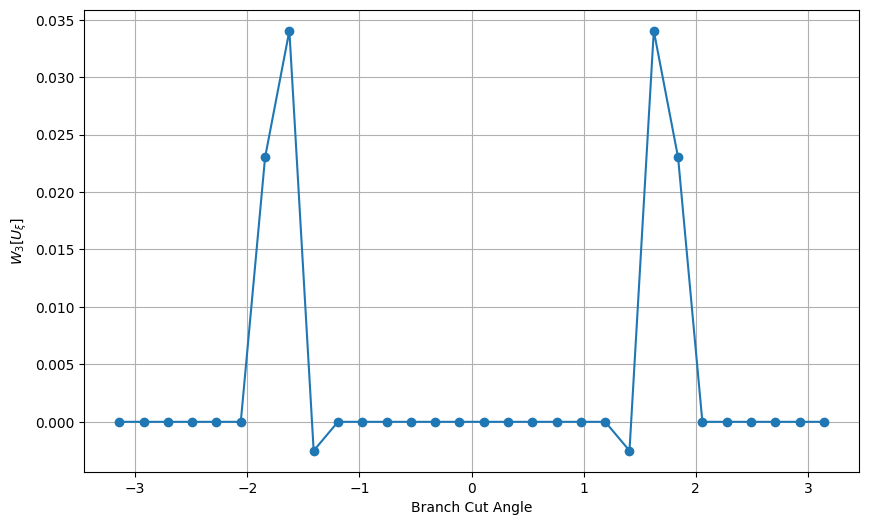

In [14]:
w3_1 = model_pest.winding3(40, 100, branch_cut_angle=branch_cut_angles, plot= True)

In [226]:
grid50 = model_pest2.eigen_grid(0, 100, 100)

In [ ]:
eigengrid_24_31 = grid50[2][] 

In [225]:
w_unc2 = model_pest2.w3(0, 100, 100)
print(w_unc2)

tensor(0., device='cuda:1', dtype=torch.float64)
tensor(-6.0644, device='cuda:1', dtype=torch.float64)
($i_1, i_2, i_3$) 49 49 63
p tensor([3.0788, 3.0788, 1.2600], device='cuda:1', dtype=torch.float64)
$C_p$ tensor([ 1., -1.], device='cuda:1', dtype=torch.float64)
$M_p$ tensor([1., 0.], device='cuda:1', dtype=torch.float64)
$F_p$ tensor([[ 0.0494, -0.0494],
        [ 0.0225, -0.0225],
        [ 0.1044, -0.1044]], device='cuda:1', dtype=torch.float64)
$m_p$ tensor([[0, 0],
        [0, 0],
        [0, 0]], device='cuda:1')


tensor(0., device='cuda:1', dtype=torch.float64)
tensor(-6.0644, device='cuda:1', dtype=torch.float64)
($i_1, i_2, i_3$) 99 99 63
p tensor([6.2204, 6.2204, 1.2600], device='cuda:1', dtype=torch.float64)
$C_p$ tensor([ 1., -1.], device='cuda:1', dtype=torch.float64)
$M_p$ tensor([1., 0.], device='cuda:1', dtype=torch.float64)
$F_p$ tensor([[ 0.0494, -0.0494],
        [ 0.0225, -0.0225],
        [ 0.1044, -0.1044]], device='cuda:1', dtype=torch.float64)
$m_p$ tensor([

In [228]:
grid100 = model_pest2.eigen_grid(torch.pi/2, 100, 100)

In [227]:
w_unc21 = model_pest2.w3(torch.pi/2, 100, 100)
print(w_unc21)

tensor(0., device='cuda:1', dtype=torch.float64)
tensor(-6.2588, device='cuda:1', dtype=torch.float64)
($i_1, i_2, i_3$) 25 25 63
p tensor([1.5708, 1.5708, 1.2600], device='cuda:1', dtype=torch.float64)
$C_p$ tensor([ 1., -1.], device='cuda:1', dtype=torch.float64)
$M_p$ tensor([1., 0.], device='cuda:1', dtype=torch.float64)
$F_p$ tensor([[ 0.4066, -0.4066],
        [ 0.3419, -0.3419],
        [ 0.1052, -0.1052]], device='cuda:1', dtype=torch.float64)
$m_p$ tensor([[0, 0],
        [0, 0],
        [0, 0]], device='cuda:1')


tensor(0., device='cuda:1', dtype=torch.float64)
tensor(-6.0644, device='cuda:1', dtype=torch.float64)
($i_1, i_2, i_3$) 74 74 63
p tensor([4.6496, 4.6496, 1.2600], device='cuda:1', dtype=torch.float64)
$C_p$ tensor([ 1., -1.], device='cuda:1', dtype=torch.float64)
$M_p$ tensor([1., 0.], device='cuda:1', dtype=torch.float64)
$F_p$ tensor([[ 0.0494, -0.0494],
        [ 0.0225, -0.0225],
        [ 0.1044, -0.1044]], device='cuda:1', dtype=torch.float64)
$m_p$ tensor([

tensor(0., device='cuda:1', dtype=torch.float64)
tensor(-0.5633, device='cuda:1', dtype=torch.float64)
$F_p$ tensor([[-0.0198,  0.0198],
        [-0.3609,  0.3609],
        [ 0.0037, -0.0037]], device='cuda:1', dtype=torch.float64)
$m_p$ tensor([[ 1, -1],
        [ 0,  0],
        [ 1, -1]], device='cuda:1')


$F_p$ tensor([[ 0.0508, -0.0508],
        [ 0.0570, -0.0570],
        [-0.0007,  0.0007]], device='cuda:1', dtype=torch.float64)
$m_p$ tensor([[-1,  1],
        [ 0,  0],
        [-1,  1]], device='cuda:1')


$F_p$ tensor([[-0.0187,  0.0187],
        [-0.3938,  0.3938],
        [ 0.0063, -0.0063]], device='cuda:1', dtype=torch.float64)
$m_p$ tensor([[ 1, -1],
        [ 0,  0],
        [ 1, -1]], device='cuda:1')


$F_p$ tensor([[ 0.0502, -0.0502],
        [ 0.1064, -0.1064],
        [-0.0017,  0.0017]], device='cuda:1', dtype=torch.float64)
$m_p$ tensor([[-1,  1],
        [ 0,  0],
        [-1,  1]], device='cuda:1')


$F_p$ tensor([[-0.0165,  0.0165],
        [-0.4176,  0.4176],

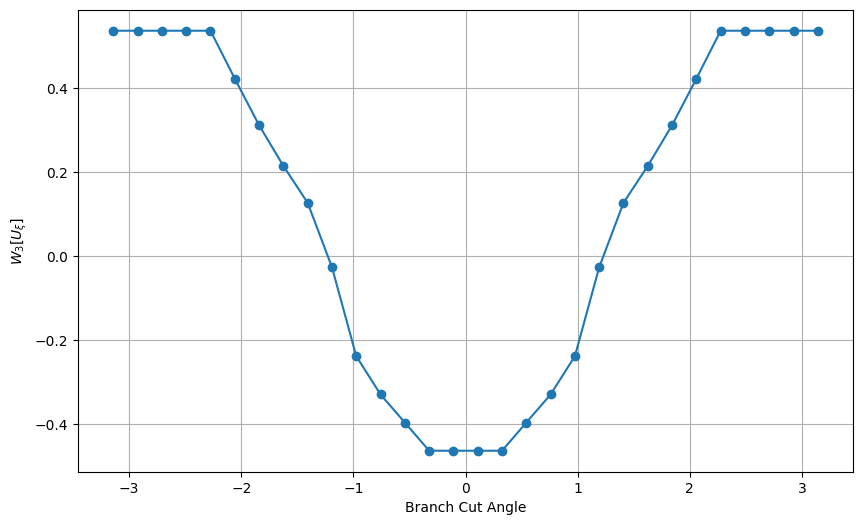

In [128]:
w3_2 = model_pest2.winding3(0, 30, 100, branch_cut_angle=branch_cut_angles, plot=True, delta=None, reverse=True)

tensor(-0.3581, device='cuda:1', dtype=torch.float64)
tensor(-0.6252, device='cuda:1', dtype=torch.float64)
tensor(-0.2853, device='cuda:1', dtype=torch.float64)
tensor(-0.4074, device='cuda:1', dtype=torch.float64)
tensor(-0.2503, device='cuda:1', dtype=torch.float64)
tensor(-0.3039, device='cuda:1', dtype=torch.float64)
tensor(-0.4488, device='cuda:1', dtype=torch.float64)
tensor(-0.4290, device='cuda:1', dtype=torch.float64)
tensor(-0.0576, device='cuda:1', dtype=torch.float64)
tensor(0.3689, device='cuda:1', dtype=torch.float64)
tensor(-0.4334, device='cuda:1', dtype=torch.float64)
tensor(-0.0873, device='cuda:1', dtype=torch.float64)
$F_p$ tensor([[-0.0022,  0.0022],
        [-0.0159,  0.0159],
        [-0.0964,  0.0964]], device='cuda:1', dtype=torch.float64)
$m_p$ tensor([[ 1, -1],
        [ 0,  0],
        [ 0,  0]], device='cuda:1')


$F_p$ tensor([[-0.0010,  0.0010],
        [-0.1258,  0.1258],
        [-0.0736,  0.0736]], device='cuda:1', dtype=torch.float64)
$m_p$ tensor([[

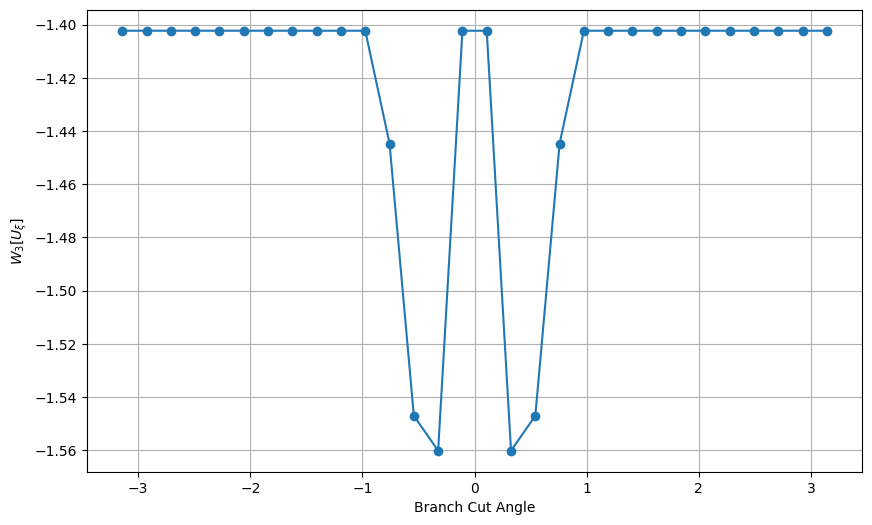

In [124]:
w3_3 = model_pest3.winding3(0, 35, 100, branch_cut_angle=branch_cut_angles, plot= True)

In [14]:
model_tts = afai_parallel.tb_floquet_tbc_cuda(period, 1, hopping1, ny= 2, nx = 2)
model_fti = afai_parallel.tb_floquet_tbc_cuda(period, 1, hopping2, ny = 2, nx = 2)
model_ano_flo = afai_parallel.tb_floquet_tbc_cuda(period, 1, hopping3, ny=2, nx=2)

In [15]:
vd1 = 7 * period

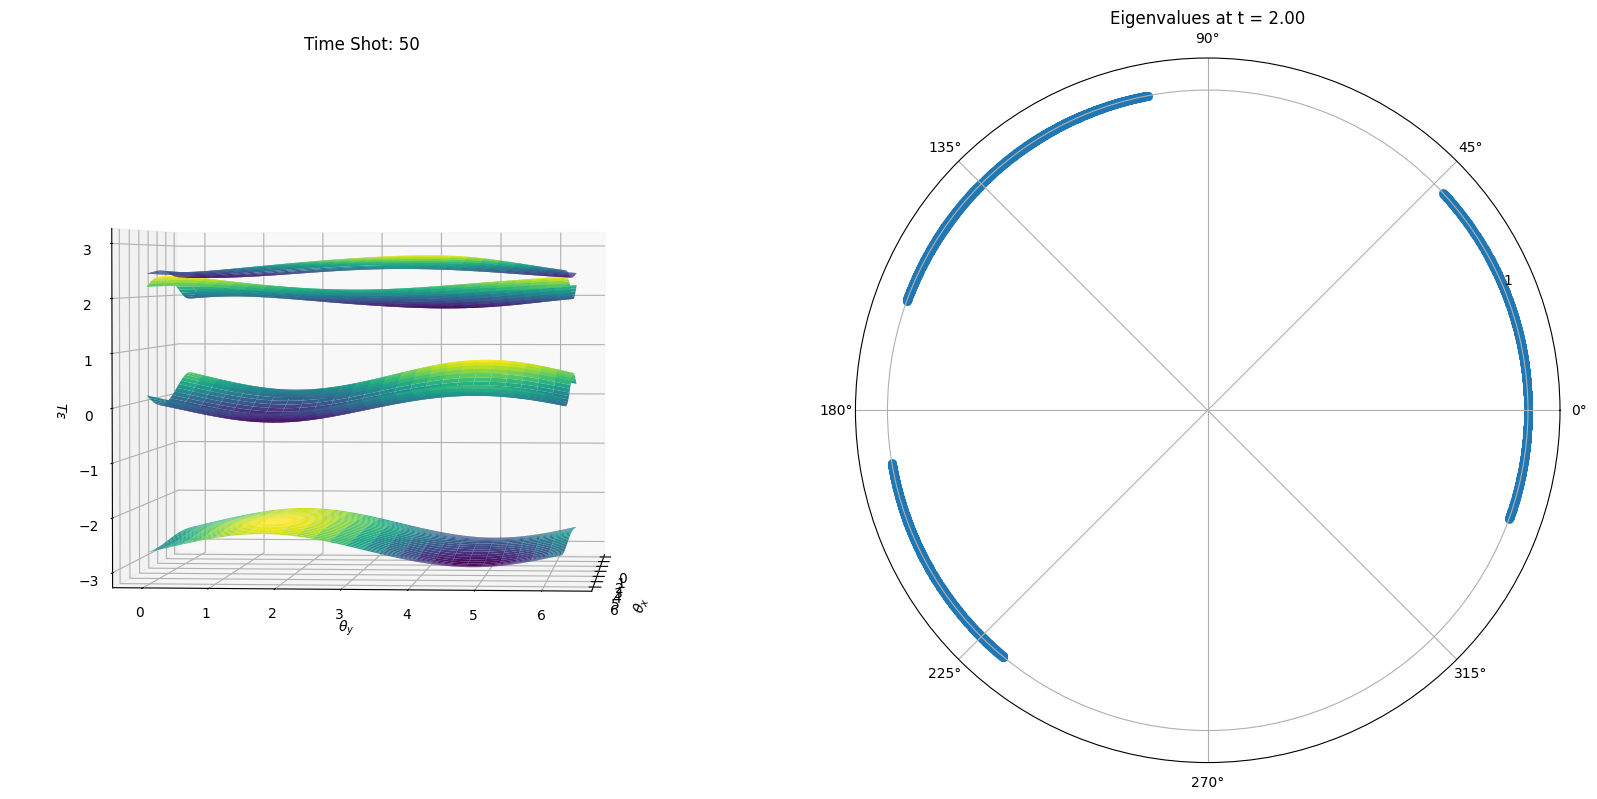

In [16]:
video_fti = model_fti.animate_time_spectra(vd1, 50, 1000, fully_disorder= True, filename = "fti_vd1.mp4")

In [11]:
period1 = 4
period2 = 100
hopping1 = - np.pi/(2)
hopping2 = - 3 * np.pi/(2)
hopping3 = - 5 * np.pi/(2)
model_afai2 = afai_parallel.tb_floquet_tbc_cuda(period1, 1, hopping3, ny = 2, nx = 2, device='cpu')
model_afai2_4band = afai_parallel.tb_floquet_tbc_cuda(period1, 1, hopping3, ny = 2, nx = 2, device='cuda:0')
model_afai3 = afai_parallel.tb_floquet_tbc_cuda(period2, 1, hopping3, ny = 2, nx = 80, device='cuda:0')
# model_afai2_cuda = afai_cuda.tb_floquet_tbc_cuda(period1, 1, hopping3, ny = 2, nx = 80, device='cuda:0')
# model_afai3_cuda = afai_cuda.tb_floquet_tbc_cuda(period2, 1, hopping3, ny = 2, nx = 80, device='cuda:0')

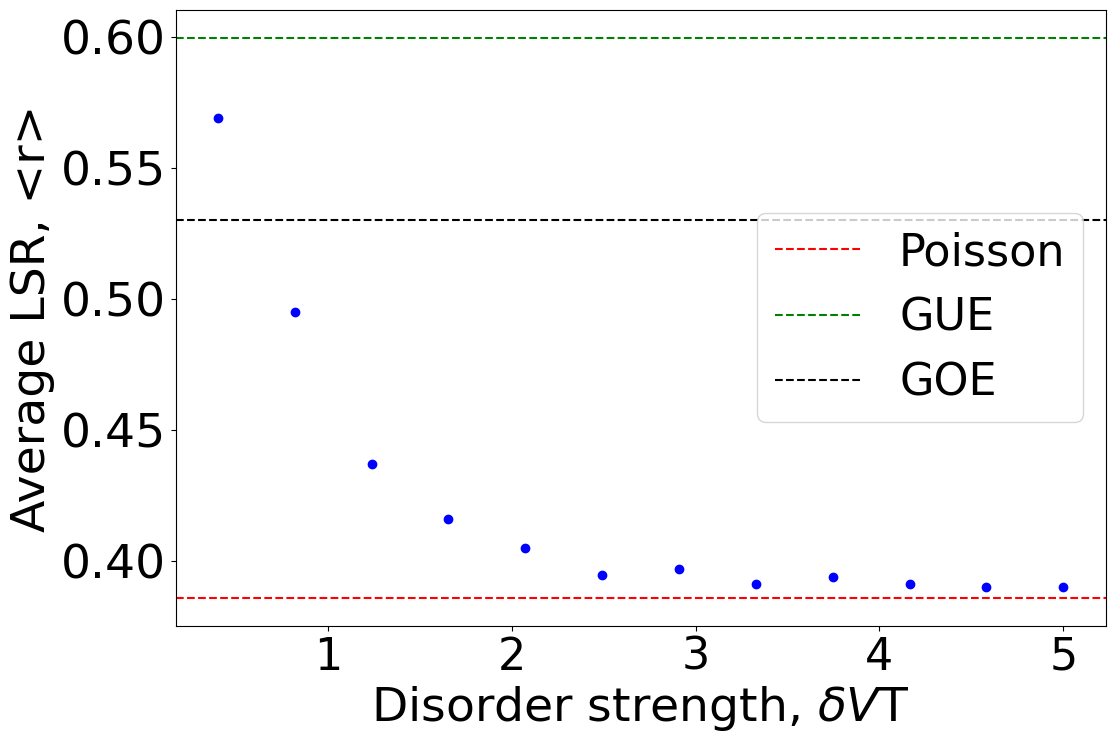

In [8]:
avg_LSR1 = model_afai2.avg_LSR__disorder_realisation(100, 0.4, 5, 12, 15)

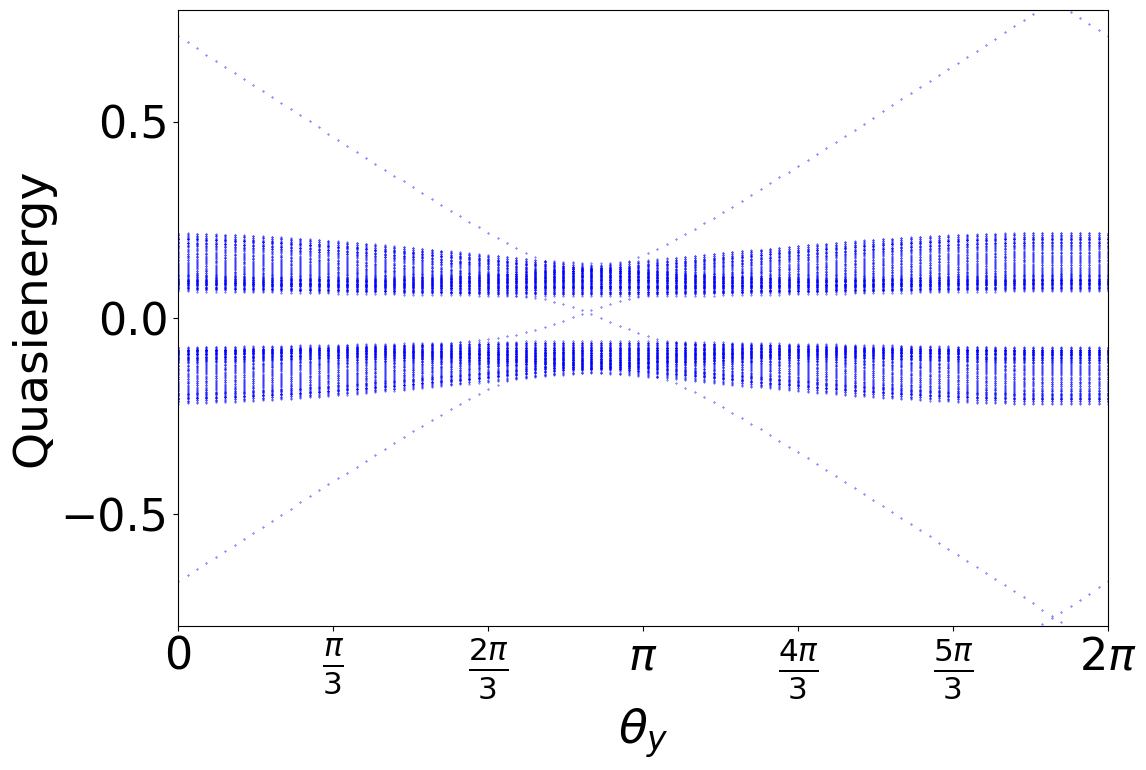

In [10]:
quasi_spectra1 = model_afai2.quasienergies_states_edge(100, 'y', 0.2, theta_p_num=100, fully_disorder= True, plot= True)

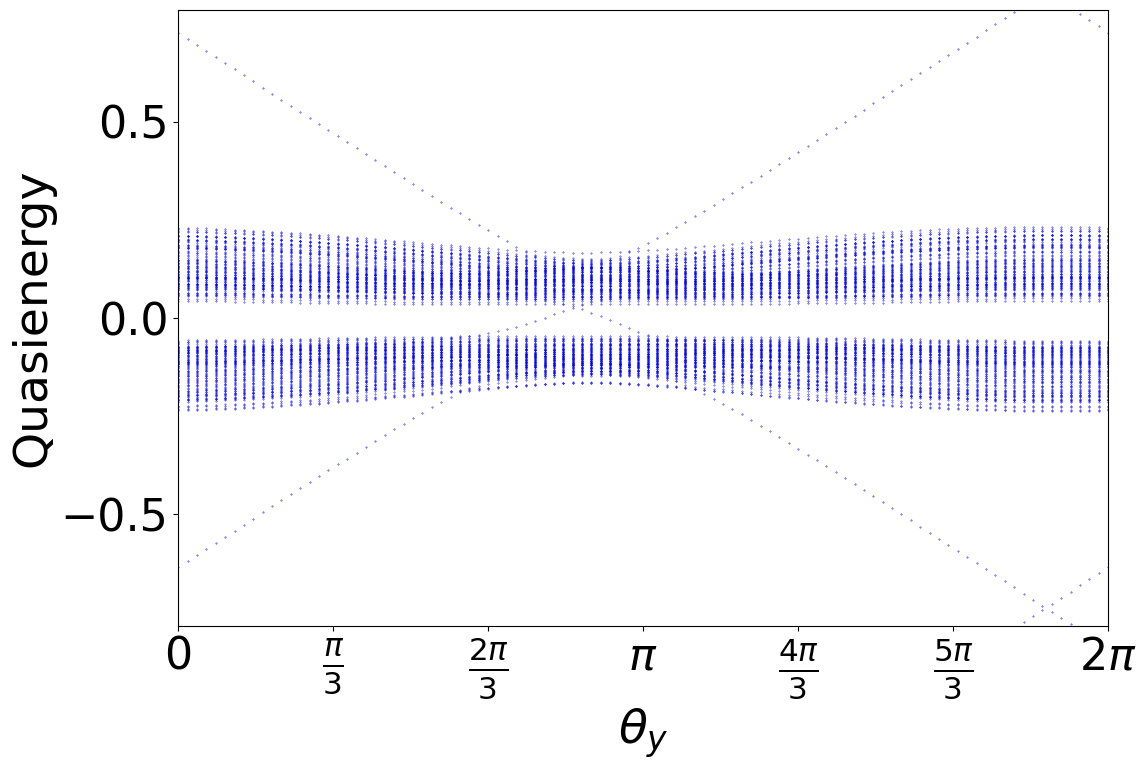

In [11]:
quasi_spectra1 = model_afai2.quasienergies_states_edge(100, 'y', 0.4, theta_p_num=100, fully_disorder= True, plot= True)

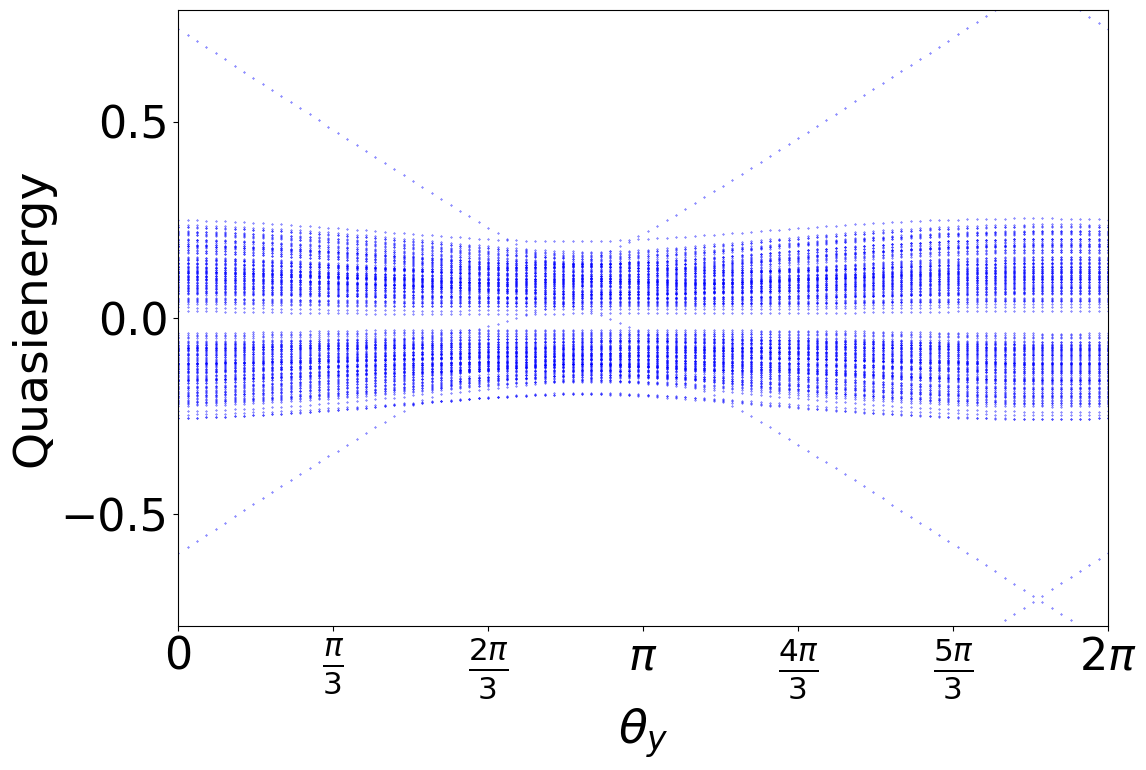

In [12]:
quasi_spectra1 = model_afai2.quasienergies_states_edge(100, 'y', 0.6, theta_p_num=100, fully_disorder= True, plot= True)

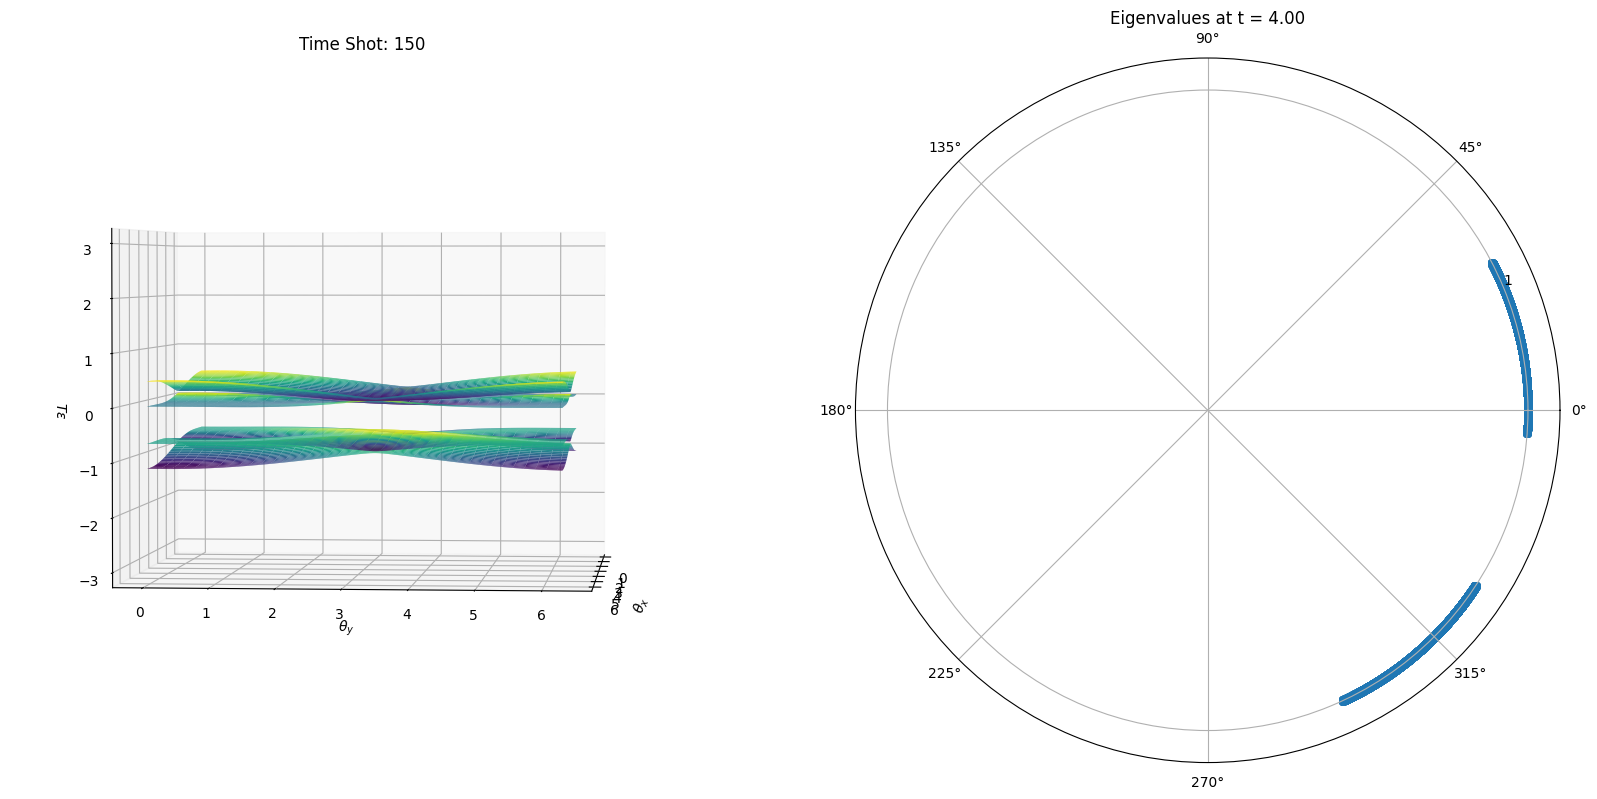

In [18]:
video = model_afai2_4band.animate_time_spectra(0.6, 150, 100, fully_disorder=True, filename='afai_4bands1.mp4')

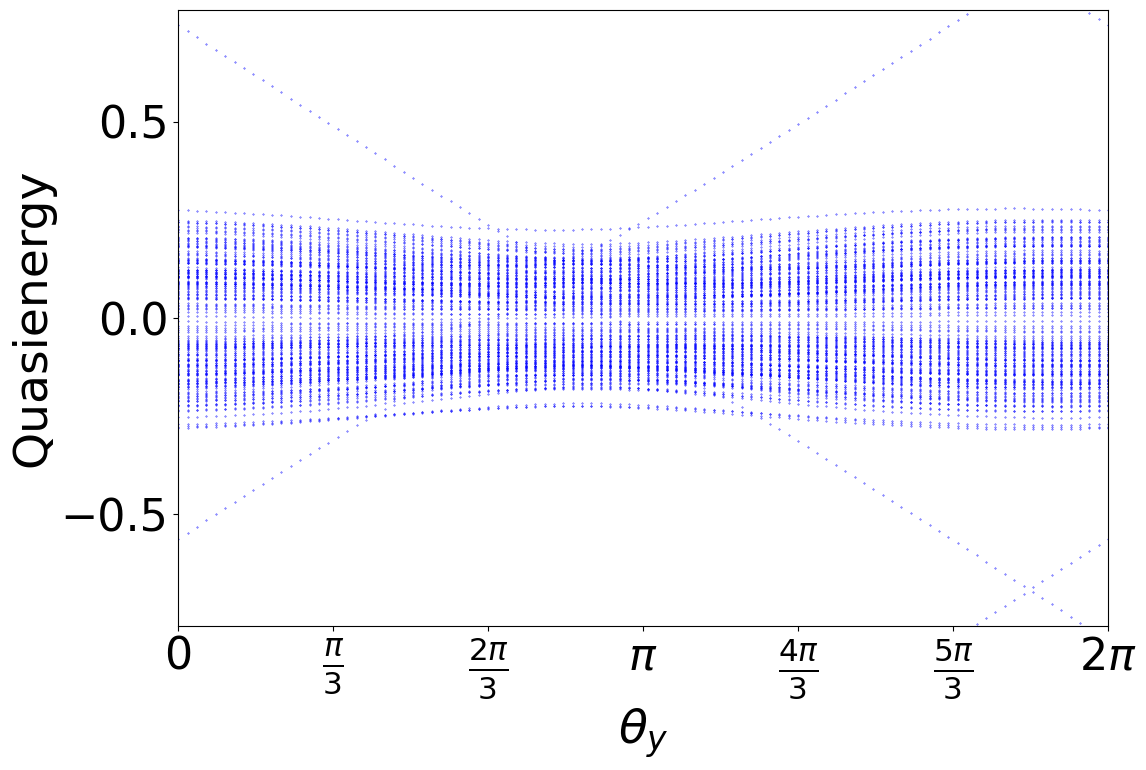

In [13]:
quasi_spectra1 = model_afai2.quasienergies_states_edge(100, 'y', 0.8, theta_p_num=100, fully_disorder= True, plot= True)

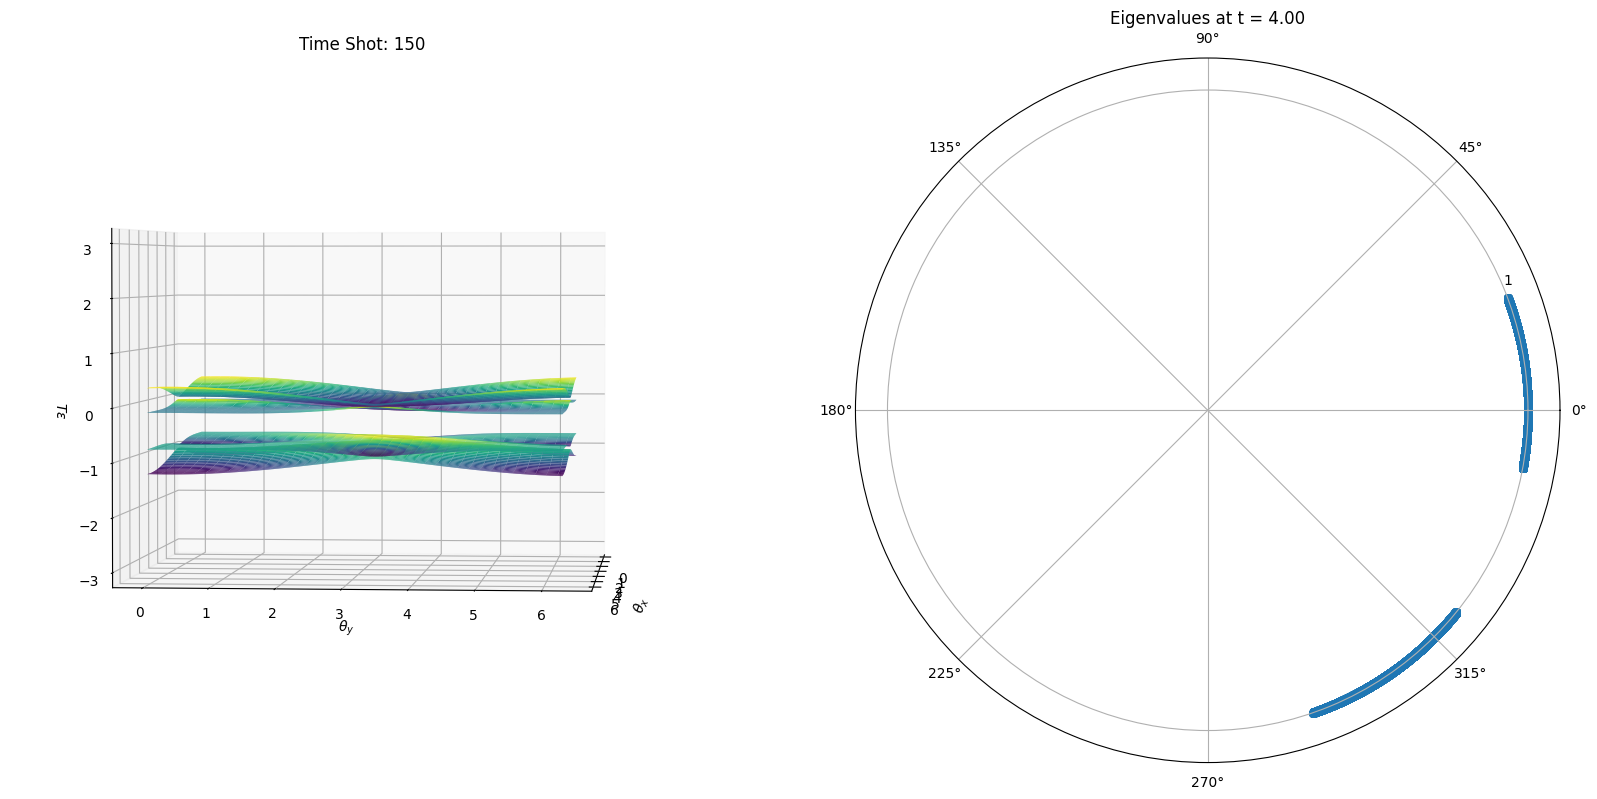

In [19]:
video3 = model_afai2_4band.animate_time_spectra(0.8, 150, 100, fully_disorder=True, filename='afai_4bands2.mp4')

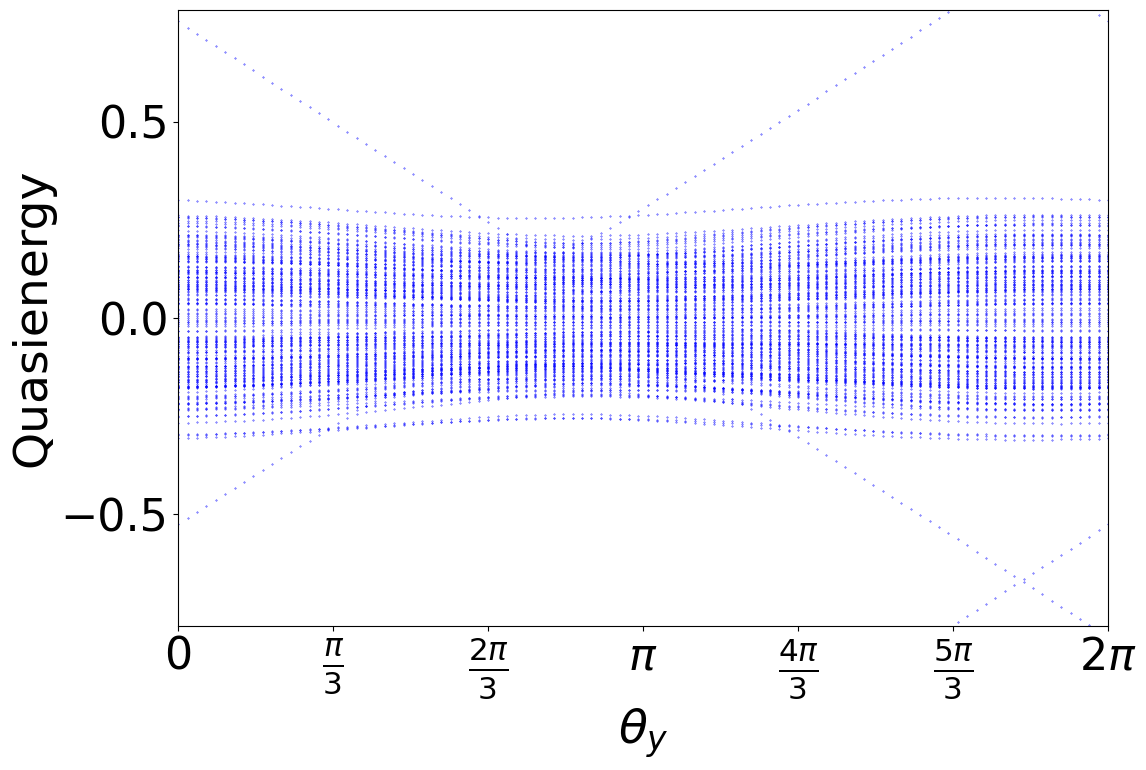

In [14]:
quasi_spectra1 = model_afai2.quasienergies_states_edge(100, 'y', 1, theta_p_num=100, fully_disorder= True, plot= True)

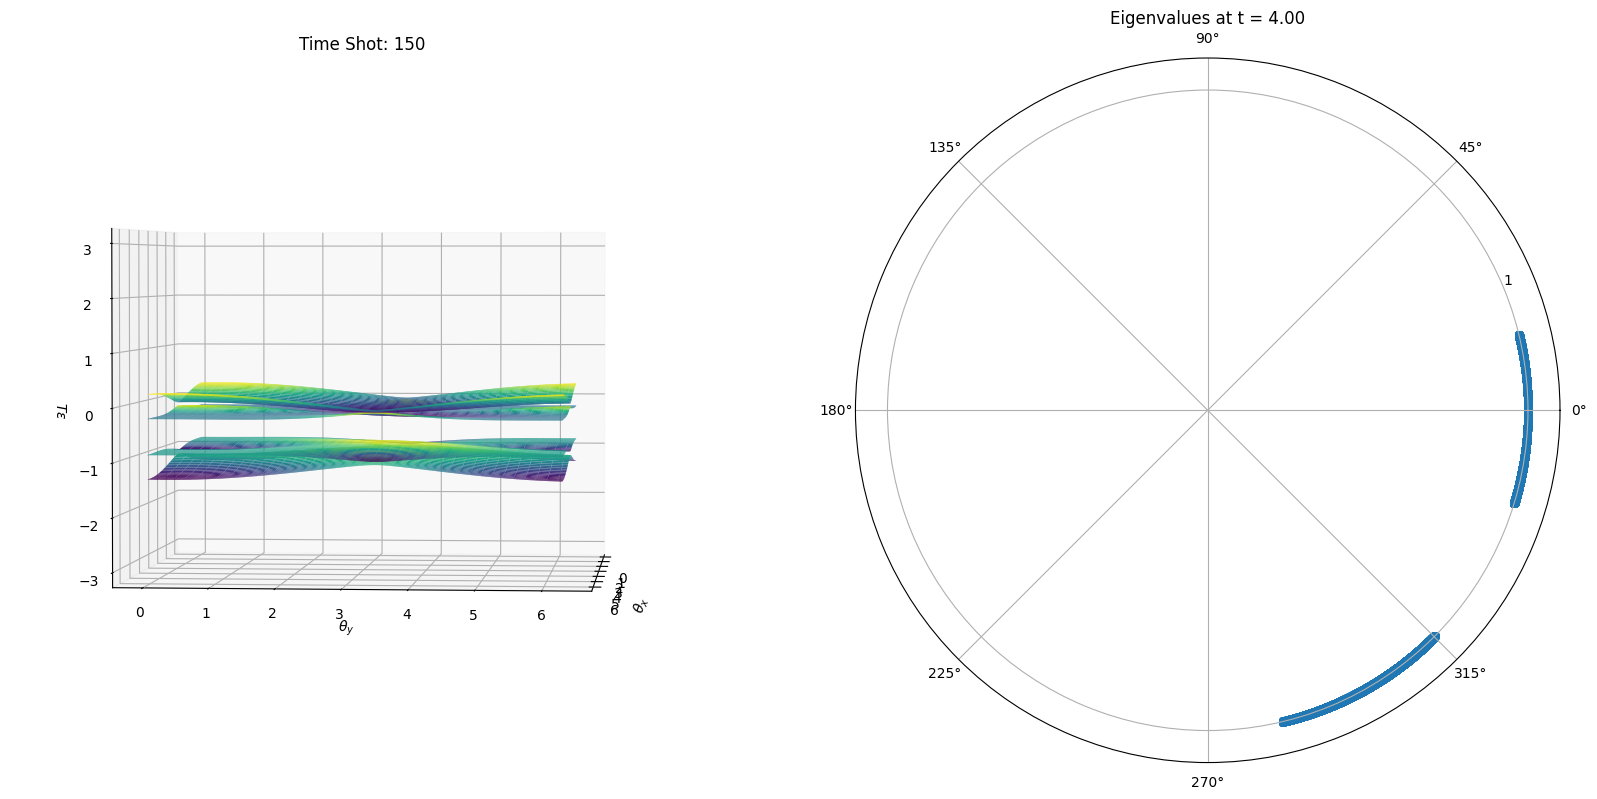

In [20]:
video3 = model_afai2_4band.animate_time_spectra(1, 150, 100, fully_disorder=True, filename='afai_4bands3.mp4')

In [41]:
t = torch.tensor([1,2,3,4])
thetax = torch.tensor([1,2,3])

In [42]:
derivative_H = model_afai2_4band.derivative_H_tbc(t,'x', thetax, 0)

In [43]:
model_afai2_4band.T

4

In [44]:
print(derivative_H.shape)
print(derivative_H[0])

torch.Size([3, 4, 4, 4])
tensor([[[ 0.0000+0.0000j, -1.6522-1.0609j,  0.0000+0.0000j,  0.0000+0.0000j],
         [-1.6522+1.0609j,  0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j],
         [ 0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j],
         [ 0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j]],

        [[ 0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j],
         [ 0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j],
         [ 0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j],
         [ 0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j]],

        [[ 0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j],
         [ 0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j],
         [ 0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j, -1.6522-1.0609j],
         [ 0.0000+0.0000j,  0.0000+0.0000j, -1.6522+1.0609j,  0.0000+0.0000j]],

        [[ 0.0000+0.0

In [29]:
def single_wf_dic(size, l):
    idn = torch.eye(size)
    dic = idn[:,:2]
    return dic

In [30]:
single_wf_dic(3,2)

tensor([[1., 0.],
        [0., 1.],
        [0., 0.]])

In [41]:
def levi_civita(permutation):
    """
    Calculate the Levi-Civita symbol for a given permutation.

    Parameters:
    permutation (tuple): A permutation of indices.

    Returns:
    int: The Levi-Civita symbol (1, -1, or 0).
    """
    n = len(permutation)
    sign = 1
    for i in range(n):
        for j in range(i + 1, n):
            if permutation[i] > permutation[j]:
                sign *= -1
    return sign

In [50]:
levi_civita((3,2,1))

-1

In [4]:
import torch
import numpy as np
from itertools import permutations
import gc

def single_wf_dic(size, l):
    """
    Create a matrix to store the single-particle wavefunctions.

    Parameters:
    size (int): Total number of sites.
    l (int): Number of occupied sites (columns to keep).

    Returns:
    torch.Tensor: Matrix with the first l columns of the identity matrix.
    """
    # Create the identity matrix
    idn = torch.eye(size)
    
    # Slice to keep the first l columns
    dic = idn[:, :l]
    
    return dic

def levi_civita(permutation):
    """
    Calculate the Levi-Civita symbol for a given permutation.

    Parameters:
    permutation (tuple): A permutation of indices.

    Returns:
    int: The Levi-Civita symbol (1, -1, or 0).
    """
    n = len(permutation)
    sign = 1
    for i in range(n):
        for j in range(i + 1, n):
            if permutation[i] > permutation[j]:
                sign *= -1
    return sign

def construct_slater_determinant(size, l):
    """
    Construct the Slater determinant for a system with a given number of sites and occupied states.

    Parameters:
    size (int): Total number of sites.
    l (int): Number of occupied sites (fermions).

    Returns:
    torch.Tensor: Slater determinant wavefunction.
    """
    # Get the single-particle wavefunctions matrix
    wf_matrix = single_wf_dic(size, l)
    
    # Initialize the Slater determinant wavefunction
    slater_det = torch.zeros((size**l,))
    
    # Generate all permutations of the column indices
    indices = list(range(l))
    all_permutations = permutations(indices)
    
    # Compute the Slater determinant
    for perm in all_permutations:
        sign = levi_civita(perm)
        if sign != 0:
            term = wf_matrix[:, perm[0]]
            for idx in perm[1:]:
                term = torch.kron(term, wf_matrix[:, idx])
            slater_det += sign * term

    return slater_det

def construct_slater_determinant(size, l):
    """
    Construct the Slater determinant for a system with a given number of sites and occupied states.

    Parameters:
    size (int): Total number of sites.
    l (int): Number of occupied sites (fermions).

    Returns:
    torch.Tensor: Slater determinant wavefunction.
    """
    # Get the single-particle wavefunctions matrix
    wf_matrix = single_wf_dic(size, l)
    
    # Initialize the Slater determinant wavefunction list
    slater_det_list = []
    
    # Generate all permutations of the column indices
    indices = list(range(l))
    all_permutations = permutations(indices)
    
    # Compute the Slater determinant
    for perm in all_permutations:
        sign = levi_civita(perm)
        term = wf_matrix[:, perm[0]]
        for idx in perm[1:]:
            term = torch.kron(term, wf_matrix[:, idx])
        slater_det_list.append(sign * term)
        del term  # Free memory for the intermediate tensor
        gc.collect()  # Ensure garbage collection
    
    # Sum the terms to form the final Slater determinant wavefunction
    slater_det = sum(slater_det_list)
    del slater_det_list  # Free memory for the list
    gc.collect()  # Ensure garbage collection

    return slater_det

In [5]:
# Example usage
size = 12  # Total number of sites
l = 6     # Number of occupied sites (fermions)

In [6]:
slater_wavefunction = construct_slater_determinant(size, l)

In [9]:
def free_memory():
    # Delete all variables (you may need to customize this for your use case)
    globals().clear()
    
    # Run the garbage collector to free up memory
    gc.collect()

# Example usage: Call this function when you encounter a memory error
try:
    # Your code that may cause memory errors
    slater_wavefunction = construct_slater_determinant(size, l)
except RuntimeError as e:
    print(f"RuntimeError: {e}")
    free_memory()

In [10]:
# Compare the two tensors
if torch.equal(slater_wavefunction, wf):
    print("The Slater wavefunctions are identical.")
else:
    print("The Slater wavefunctions are different.")

The Slater wavefunctions are identical.


In [159]:
vd_tensor = torch.linspace(0, 6, 6)
print(vd_tensor)

tensor([0.0000, 1.2000, 2.4000, 3.6000, 4.8000, 6.0000])


In [14]:
model_afai2 = afai_parallel.tb_floquet_tbc_cuda(period1, 1, hopping3, ny = 2, nx = 2, device='cuda:1')

In [147]:
floquet_wf = model_afai2.floquet_state_t(1, 0, 10, 100, 1)

In [148]:
print(floquet_wf[1].shape)

torch.Size([11, 36, 36])


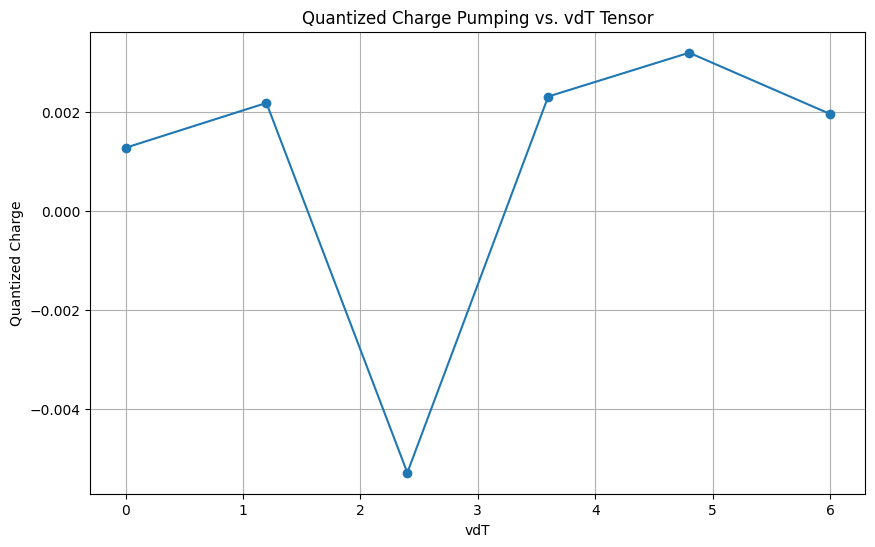

In [177]:
model_afai2.plot_quantised_charge(vd_tensor, 30, 100, fully_disorder=True)

In [149]:
thetax = 0
thetay = 0
t_batch = torch.tensor([0,0.5,1, 1.5])

In [150]:
dH = model_afai2.derivative_H_tbc(t_batch, 'x', thetax, thetay)

In [151]:
integration = model_afai2.simpson_integration(1, 2, 20, 100, 1, fully_disorder=True)

In [152]:
print(integration[0].shape)

torch.Size([36])


In [153]:
print(integration[0])

tensor([ 0.0809, -0.2217,  0.2224, -0.0410,  0.0332,  0.2863,  0.0580, -0.0874,
         0.0402, -0.0417,  0.1590, -0.0124, -0.0805, -0.1740,  0.1147,  0.5268,
        -0.0199, -0.2662, -0.0378, -0.0667,  0.0655, -0.1410, -0.0252, -0.0346,
        -0.0317, -0.1020, -0.0333,  0.0210,  0.0308, -0.1340, -0.0787,  0.0894,
         0.0726,  0.0127, -0.1199, -0.0637], dtype=torch.float64)


In [154]:
wf_ini = model_afai2.single_p_wf_ini()
print(wf_ini)

tensor([0.2357+0.j, 0.2357+0.j, 0.2357+0.j, 0.2357+0.j, 0.2357+0.j, 0.2357+0.j, 0.2357+0.j,
        0.2357+0.j, 0.2357+0.j, 0.2357+0.j, 0.2357+0.j, 0.2357+0.j, 0.2357+0.j, 0.2357+0.j,
        0.2357+0.j, 0.2357+0.j, 0.2357+0.j, 0.2357+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j,
        0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j,
        0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j,
        0.0000+0.j], dtype=torch.complex128)


In [155]:
torch.set_printoptions(edgeitems=torch.inf)
print(integration[1][-1])

tensor([[-3.7995e-06+1.0111e-05j,  1.4455e-01-2.4084e-02j,
         -6.0805e-03-8.9259e-03j,  3.0412e-02+1.5333e-01j,
         -2.7559e-02-3.0991e-02j, -1.9897e-02-1.3043e-02j,
         -2.3229e-02+1.2474e-01j,  2.5576e-02-1.2210e-02j,
          2.7788e-02-1.5782e-01j, -4.9312e-02-5.9936e-02j,
         -2.1933e-01-7.7783e-01j,  2.0408e-02+1.1881e-01j,
         -6.1288e-04+2.0249e-02j,  1.1106e-01-7.8487e-02j,
         -9.6587e-02-3.9614e-02j,  2.8938e-02-2.8877e-02j,
          1.5076e-02-2.8032e-02j, -2.0048e-02+4.4150e-02j,
          1.6112e-02-4.3184e-02j, -4.7657e-02-9.1783e-03j,
          2.2406e-01+6.8873e-02j, -2.0549e-01-9.5329e-02j,
         -1.0828e-02+3.4845e-03j,  4.3895e-02-3.7289e-02j,
         -2.9234e-02+9.7677e-03j, -2.3145e-01+1.0004e-01j,
         -4.6354e-02-3.5873e-02j, -2.2923e-02-1.6534e-02j,
          2.8926e-02+4.3649e-02j,  5.3922e-04-2.2369e-03j,
         -8.7659e-03-4.1333e-03j,  2.4725e-03-2.6240e-03j,
          1.0278e-01+7.7130e-03j,  2.1296e-02-1.0009e-02

In [156]:
nj = model_afai2.nj_single_particle(wf_ini, integration[1])
print(nj)

tensor([0.0356, 0.0165, 0.1016, 0.0127, 0.0223, 0.0188, 0.0027, 0.1040, 0.0092,
        0.0333, 0.0185, 0.0351, 0.0043, 0.0053, 0.0001, 0.0011, 0.0023, 0.0011,
        0.0054, 0.0630, 0.0137, 0.0470, 0.0013, 0.0779, 0.0769, 0.0354, 0.0313,
        0.0075, 0.0496, 0.0067, 0.0088, 0.0784, 0.0018, 0.0648, 0.0041, 0.0020],
       dtype=torch.float64)


In [157]:
quantized_charge = torch.sum(nj * integration[0])

In [158]:
print(quantized_charge)

tensor(0.0064, dtype=torch.float64)


In [105]:
theta = torch.linspace(0, 2 * torch.pi, 2, dtype=torch.float64)

In [106]:
matrix = model_afai2.time_evolution_operator1(model_afai2.T,100, 'x', 2, torch.pi/4, theta, 0)

In [107]:
print(matrix[0].shape)

torch.Size([4, 4])


In [108]:
E1, eigvec1 = torch.linalg.eig(matrix)

In [112]:
print(eigvec1[0])

tensor([[ 0.8783+0.0000j,  0.0473+0.4149j,  0.1603-0.1563j, -0.0304-0.0554j],
        [-0.2268-0.0715j,  0.2084+0.0873j,  0.9435+0.0000j, -0.0467-0.0079j],
        [ 0.0116+0.4127j,  0.8768+0.0000j, -0.1621+0.1790j, -0.0470-0.0172j],
        [ 0.0233-0.0311j,  0.0764-0.0027j,  0.0359-0.0099j,  0.9956+0.0000j]],
       dtype=torch.complex128)


In [117]:
E, eigvec = model_afai2.quasienergies_states_edge(100, 'x', 2, 2)

Original eigvecs shape: torch.Size([2, 4, 4])
Original eigvecs norm: tensor([[1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000]], dtype=torch.float64)
tensor([[ 0.8783+0.0000j,  0.0473+0.4149j,  0.1603-0.1563j, -0.0304-0.0554j],
        [-0.2268-0.0715j,  0.2084+0.0873j,  0.9435+0.0000j, -0.0467-0.0079j],
        [ 0.0116+0.4127j,  0.8768+0.0000j, -0.1621+0.1790j, -0.0470-0.0172j],
        [ 0.0233-0.0311j,  0.0764-0.0027j,  0.0359-0.0099j,  0.9956+0.0000j]],
       dtype=torch.complex128)
tensor([[-0.0304-0.0554j,  0.0473+0.4149j,  0.8783+0.0000j,  0.1603-0.1563j],
        [-0.0467-0.0079j,  0.2084+0.0873j, -0.2268-0.0715j,  0.9435+0.0000j],
        [-0.0470-0.0172j,  0.8768+0.0000j,  0.0116+0.4127j, -0.1621+0.1790j],
        [ 0.9956+0.0000j,  0.0764-0.0027j,  0.0233-0.0311j,  0.0359-0.0099j]],
       dtype=torch.complex128)
Sorted eigvecs shape: torch.Size([2, 4, 4])
Sorted eigvecs norm: tensor([[1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.000

In [113]:
print(eigvec[0])

tensor([[-0.0304-0.0554j, -0.0467-0.0079j, -0.0470-0.0172j,  0.9956+0.0000j],
        [ 0.0473+0.4149j,  0.2084+0.0873j,  0.8768+0.0000j,  0.0764-0.0027j],
        [ 0.8783+0.0000j, -0.2268-0.0715j,  0.0116+0.4127j,  0.0233-0.0311j],
        [ 0.1603-0.1563j,  0.9435+0.0000j, -0.1621+0.1790j,  0.0359-0.0099j]],
       dtype=torch.complex128)


In [84]:
print(eigvec.shape)

torch.Size([2, 4, 4])


In [60]:
import torch

def check_orthonormality(eigvec, tol=1e-6):
    """
    Check if the eigenvectors are orthonormal.
    
    :param eigvec: Tensor of eigenvectors with shape [num_points, num_vectors, vector_length]
    :param tol: Tolerance for numerical precision
    :return: Bool indicating if eigenvectors are orthonormal, and a dict with detailed results
    """
    num_points, num_vectors, vector_length = eigvec.shape
    results = {'orthogonal': True, 'normal': True, 'details': []}

    for point in range(num_points):
        # Compute the Gram matrix (matrix of dot products)
        gram_matrix = torch.matmul(eigvec[point], eigvec[point].conj().transpose(-2, -1))
        
        # Check orthogonality (off-diagonal elements should be close to 0)
        off_diagonal = gram_matrix - torch.eye(num_vectors, device=eigvec.device)
        max_off_diagonal = torch.max(torch.abs(off_diagonal))
        orthogonal = max_off_diagonal < tol

        # Check normality (diagonal elements should be close to 1)
        diagonal = torch.diagonal(gram_matrix)
        normal = torch.all(torch.abs(diagonal - 1) < tol)

        results['orthogonal'] &= orthogonal
        results['normal'] &= normal
        results['details'].append({
            'point': point,
            'orthogonal': orthogonal,
            'max_off_diagonal': max_off_diagonal.item(),
            'normal': normal,
            'max_norm_deviation': torch.max(torch.abs(diagonal - 1)).item()
        })

    return results['orthogonal'] and results['normal'], results

In [92]:
check_orthonormality(eigvec1)

(tensor(True),
 {'orthogonal': tensor(True),
  'normal': tensor(True),
  'details': [{'point': 0,
    'orthogonal': tensor(True),
    'max_off_diagonal': 1.7982883547092107e-14,
    'normal': tensor(True),
    'max_norm_deviation': 1.6764367671839864e-14},
   {'point': 1,
    'orthogonal': tensor(True),
    'max_off_diagonal': 1.8084164675035318e-14,
    'normal': tensor(True),
    'max_norm_deviation': 1.6431300764452317e-14}]})

In [93]:
check_orthonormality(eigvec)

(tensor(True),
 {'orthogonal': tensor(True),
  'normal': tensor(True),
  'details': [{'point': 0,
    'orthogonal': tensor(True),
    'max_off_diagonal': 2.4251230692121637e-14,
    'normal': tensor(True),
    'max_norm_deviation': 2.220461193658883e-16},
   {'point': 1,
    'orthogonal': tensor(True),
    'max_off_diagonal': 2.4188697514871902e-14,
    'normal': tensor(True),
    'max_norm_deviation': 3.3307172134533265e-16}]})

In [69]:
check_orthonormality(eigvec_normalized)

(tensor(False),
 {'orthogonal': tensor(False),
  'normal': tensor(True),
  'details': [{'point': 0,
    'orthogonal': tensor(False),
    'max_off_diagonal': 1.000000000000001,
    'normal': tensor(True),
    'max_norm_deviation': 1.1102230246251565e-15},
   {'point': 1,
    'orthogonal': tensor(False),
    'max_off_diagonal': 1.000000000000001,
    'normal': tensor(True),
    'max_norm_deviation': 1.1102230246251565e-15}]})

In [120]:
vd_tensor = torch.linspace(0, 6, 3)
print(vd_tensor)
thetax = torch.linspace(0, 6, 3)

tensor([0., 3., 6.])


In [174]:
aa = model_afai2.floquet_state_t(2, 0, 3, 100)

In [175]:
print(aa[1])

tensor([[[-1.4438e-01-0.0861j,  3.0930e-02-0.1235j,  8.9199e-01+0.0000j,
           1.4521e-01+0.3726j],
         [-3.2361e-01-0.0733j,  9.1775e-01+0.0000j, -1.4181e-01-0.0602j,
           1.3952e-01+0.0666j],
         [-2.5413e-02-0.1155j, -1.5114e-01+0.0931j, -1.4224e-01+0.3738j,
           8.9138e-01+0.0000j],
         [ 9.2069e-01+0.0000j,  3.2340e-01-0.0737j,  1.2821e-01-0.0651j,
           1.3655e-01-0.0547j]],

        [[ 1.0679e-01+0.1298j, -7.0847e-02+0.1058j, -8.3949e-01-0.3015j,
          -1.0734e-02-0.3997j],
         [ 3.2649e-01+0.0591j, -9.1688e-01+0.0398j,  1.4429e-01+0.0540j,
          -1.4228e-01-0.0605j],
         [-2.9966e-02-0.1144j, -1.4734e-01+0.0990j, -1.2734e-01+0.3791j,
           8.9068e-01-0.0353j],
         [-1.1499e-01-0.9135j, -1.1356e-01-0.3117j, -8.0621e-02-0.1191j,
          -7.1295e-02-0.1287j]],

        [[-5.6630e-02-0.1583j,  1.0242e-01-0.0756j,  6.8818e-01+0.5675j,
          -1.2501e-01+0.3798j],
         [-3.2875e-01-0.0449j,  9.1429e-01-0.0796j,

In [17]:
grid = model_afai2.eigen_grid(1, 10, 100)

Original eigvecs (first point): tensor([[ 0.6545+0.0000e+00j, -0.0594+3.6953e-01j, -0.5588-4.9565e-03j,
          0.2744-2.0981e-01j],
        [ 0.6071+5.9250e-05j, -0.0670+2.4348e-01j,  0.6793+0.0000e+00j,
         -0.2811+1.6497e-01j],
        [-0.2221-2.2744e-01j, -0.4335+3.1393e-01j,  0.3211+2.4190e-01j,
          0.6714+0.0000e+00j],
        [ 0.0766+3.1007e-01j,  0.7139+0.0000e+00j,  0.1085+2.3013e-01j,
          0.4565+3.3944e-01j]], device='cuda:1', dtype=torch.complex128)
First sorted eigenvector (for verification): tensor([[-0.5588-4.9565e-03j,  0.2744-2.0981e-01j,  0.6545+0.0000e+00j,
         -0.0594+3.6953e-01j],
        [ 0.6793+0.0000e+00j, -0.2811+1.6497e-01j,  0.6071+5.9250e-05j,
         -0.0670+2.4348e-01j],
        [ 0.3211+2.4190e-01j,  0.6714+0.0000e+00j, -0.2221-2.2744e-01j,
         -0.4335+3.1393e-01j],
        [ 0.1085+2.3013e-01j,  0.4565+3.3944e-01j,  0.0766+3.1007e-01j,
          0.7139+0.0000e+00j]], device='cuda:1', dtype=torch.complex128)


In [25]:
thetax = torch.linspace(0,2*torch.pi, 6)

In [23]:
eigenvalues, eigenvectors = model_afai2.quasienergies_states_bulk(100, 1, thetax, thetax)

Original eigvecs (first point): tensor([[-0.2063+0.4123j,  0.7747+0.0000j,  0.0857-0.3281j, -0.2690-0.0013j],
        [ 0.3376+0.1087j,  0.0992-0.0582j,  0.7903+0.0000j,  0.4441+0.1978j],
        [-0.4301+0.0960j,  0.1915-0.0826j, -0.3140+0.0984j,  0.8087+0.0000j],
        [ 0.6837+0.0000j,  0.3262+0.4866j, -0.3779+0.0962j,  0.1776-0.0760j]],
       device='cuda:1', dtype=torch.complex128)
First sorted eigenvector (for verification): tensor([[-0.2063+0.4123j,  0.7747+0.0000j, -0.2690-0.0013j,  0.0857-0.3281j],
        [ 0.3376+0.1087j,  0.0992-0.0582j,  0.4441+0.1978j,  0.7903+0.0000j],
        [-0.4301+0.0960j,  0.1915-0.0826j,  0.8087+0.0000j, -0.3140+0.0984j],
        [ 0.6837+0.0000j,  0.3262+0.4866j,  0.1776-0.0760j, -0.3779+0.0962j]],
       device='cuda:1', dtype=torch.complex128)


In [ ]:
print("Original eigvecs shape:", eigvecs.shape)
print("Original eigvecs norm:", torch.norm(eigvecs, dim=-2))
print("Original eigvecs (first point):", eigvecs[-5, -5, -5])

print("First sorted eigenvector (for verification):", sorted_eigvecs[-5, -5, -5])
print("Sorted eigenvectors shape:", sorted_eigvecs.shape)
# Check orthogonality
dot_products = torch.matmul(sorted_eigvecs.transpose(-1, -2).conj(), sorted_eigvecs)
off_diagonal = dot_products - torch.eye(dot_products.shape[-1], device=dot_products.device)
print("Max off-diagonal element:", torch.max(torch.abs(off_diagonal)))
print("Sorted eigenvectors norm:", torch.norm(sorted_eigvecs, dim=-2))

In [33]:
H1 = model_pest2.Hamiltonian_pbc3(thetax, 'y')

In [34]:
print(H1)

tensor([[[ 0.0000+0.0000e+00j,  2.3562+0.0000e+00j],
         [ 2.3562+0.0000e+00j,  0.0000+0.0000e+00j]],

        [[ 0.0000+0.0000e+00j,  0.7281-2.2409e+00j],
         [ 0.7281+2.2409e+00j,  0.0000+0.0000e+00j]],

        [[ 0.0000+0.0000e+00j, -1.9062-1.3849e+00j],
         [-1.9062+1.3849e+00j,  0.0000+0.0000e+00j]],

        [[ 0.0000+0.0000e+00j, -1.9062+1.3849e+00j],
         [-1.9062-1.3849e+00j,  0.0000+0.0000e+00j]],

        [[ 0.0000+0.0000e+00j,  0.7281+2.2409e+00j],
         [ 0.7281-2.2409e+00j,  0.0000+0.0000e+00j]],

        [[ 0.0000+0.0000e+00j,  2.3562-4.1197e-07j],
         [ 2.3562+4.1197e-07j,  0.0000+0.0000e+00j]]], device='cuda:1',
       dtype=torch.complex128)


In [35]:
H_onsite = model_pest2.Hamiltonian_pbc_onsite()
print(H_onsite)

tensor([[ 0.7854+0.j,  0.0000+0.j],
        [ 0.0000+0.j, -0.7854+0.j]], device='cuda:1', dtype=torch.complex128)


In [36]:
t = torch.linspace(0, model_pest2.T, 5)

In [37]:
U_pbc = model_pest2.time_evolution_operator_pbc1(t, 10, 1, 1, 'xy')

In [38]:
print(U_pbc.shape)

torch.Size([5, 2, 2])


In [51]:
model_pest2_x = afai_parallel.tb_floquet_pbc_cuda(period, 1, hopping2, num_y=30, device='cuda:1')
model_pest2_xy4 = afai_parallel.tb_floquet_pbc_cuda(period, 1, hopping2, num_y=2, num_x=2, device='cuda:1')

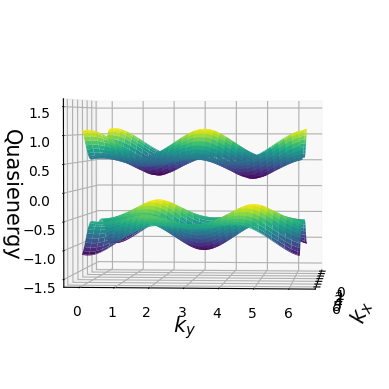

In [67]:
spectra_xy = model_pest2.quasienergy_eigenstates(model_pest2.T, 100, 100, plot = True, pbc='xy')

In [60]:
theta = torch.tensor([0,1])

In [62]:
H1 = model_pest2.Hamiltonian_pbc1(theta)

tensor([[[1.0000+0.0000j, 1.0000+0.0000j],
         [1.0000+0.0000j, 1.0000+0.0000j]],

        [[0.5403+0.8415j, 0.5403+0.8415j],
         [0.5403+0.8415j, 0.5403+0.8415j]]], device='cuda:1')
tensor(2.3562-0.j, device='cuda:1', dtype=torch.complex128)


In [63]:
print(H1)

tensor([[[0.0000+0.0000j, 2.3562+0.0000j],
         [2.3562+0.0000j, 0.0000+0.0000j]],

        [[0.0000+0.0000j, 1.2731+1.9827j],
         [1.2731-1.9827j, 0.0000+0.0000j]]], device='cuda:1',
       dtype=torch.complex128)


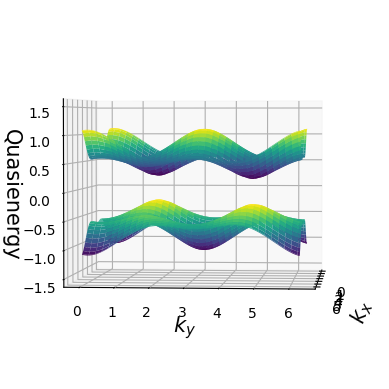

In [66]:
spectra_xy0 = model_pest2.quasienergy_eigenstates0(model_pest2.T, 100, 30, plot = True, pbc='xy')

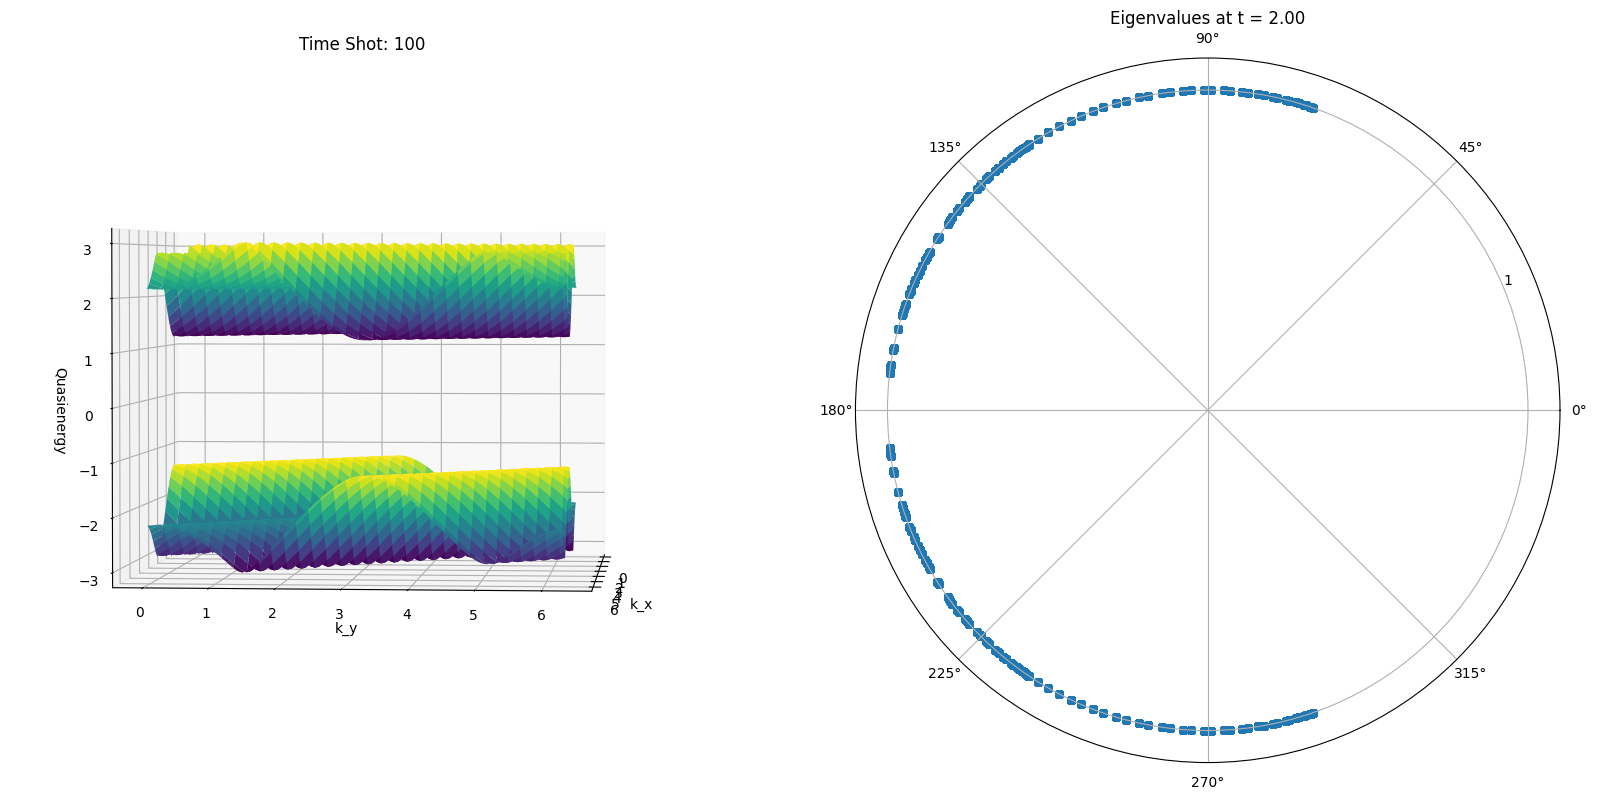

In [113]:
model_pest2.animate_combined_spectra(100, 100, ini= 0, filename = "fti_2band_noshifted.mp4")

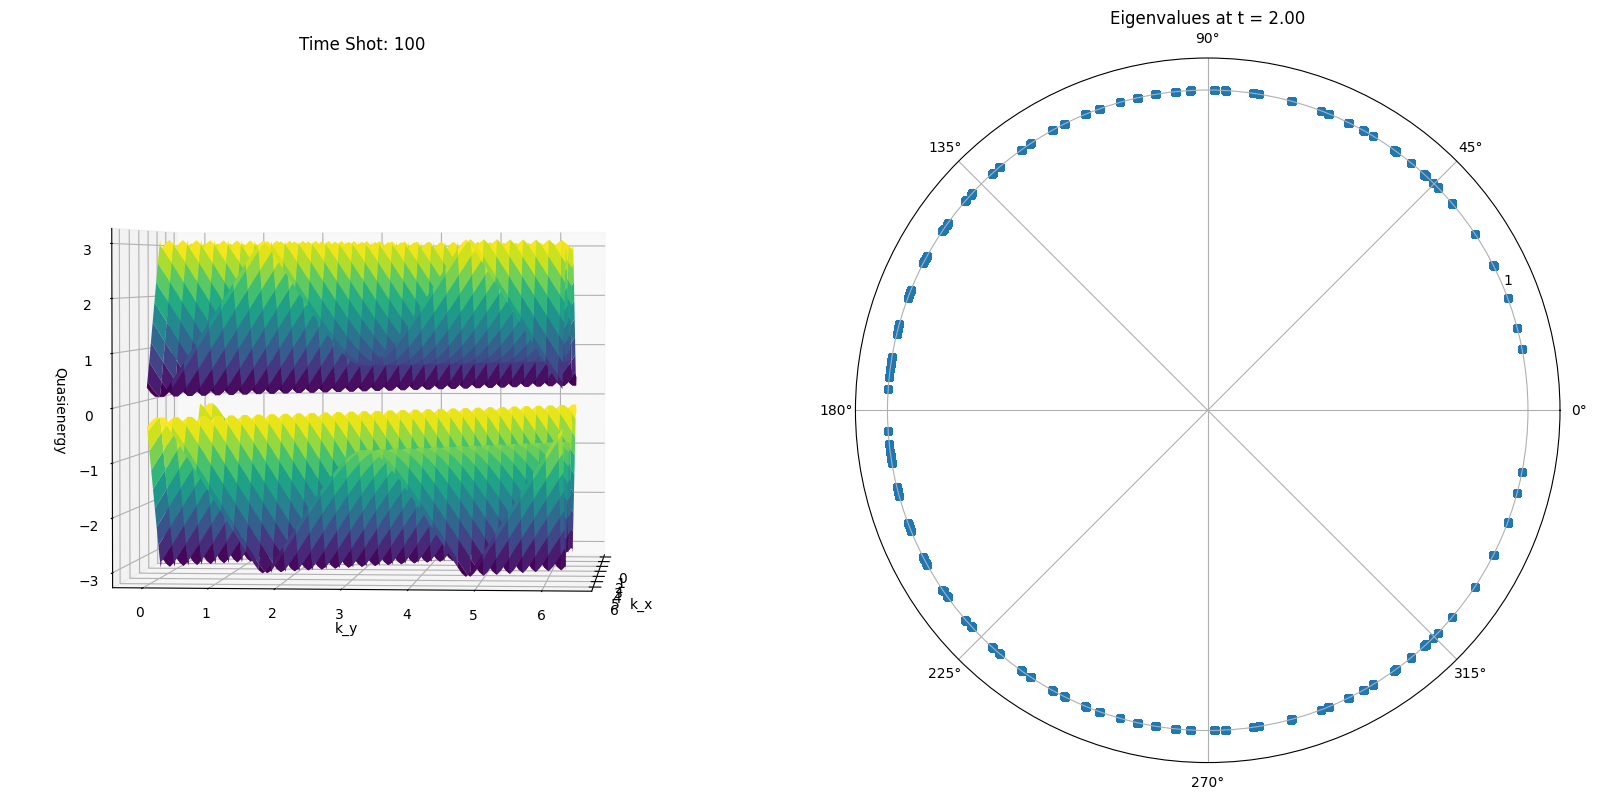

In [115]:
model_pest3.animate_combined_spectra(100, 100, ini= 0, filename = "fti_2band_noshiftedafai.mp4")

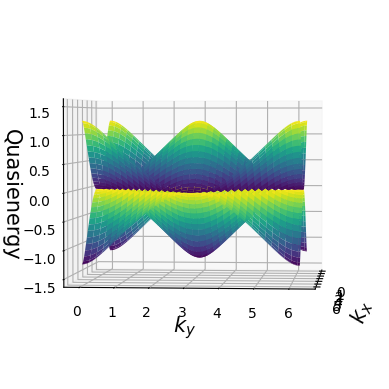

In [72]:
value, vectors = model_pest2.quasienergy_eigenstates(model_pest2.T, 100, 100, delta = 0, plot=True, pbc='xy')

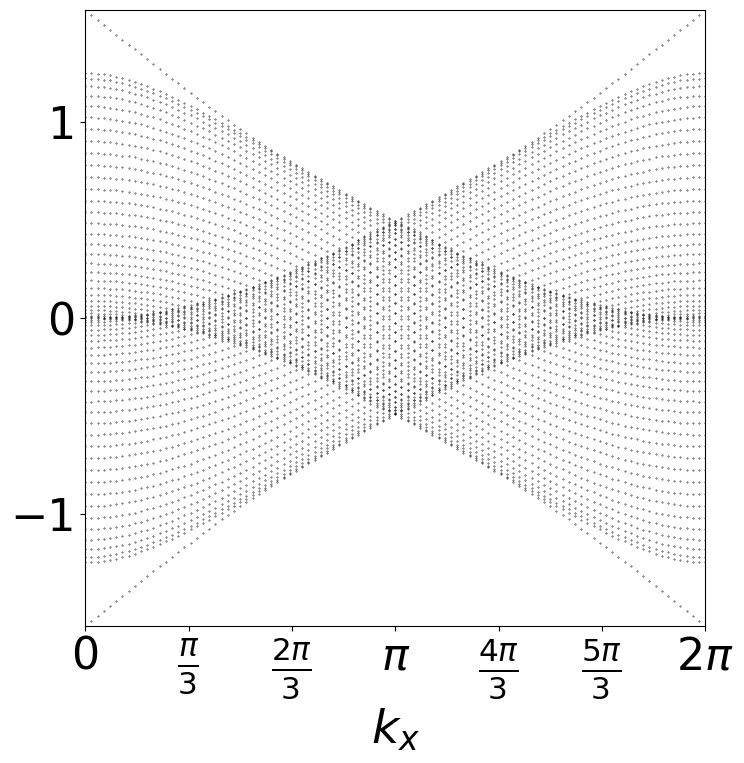

In [73]:
eigenvaluesss, eigenvectorsss = model_pest2_x.quasienergy_eigenstates(model_pest2_x.T, 100, 100, delta = 0, plot=True, pbc='x')

In [98]:
model_pest3_x = afai_parallel.tb_floquet_pbc_cuda(period, 1, hopping3, num_y=4, device='cuda:1')

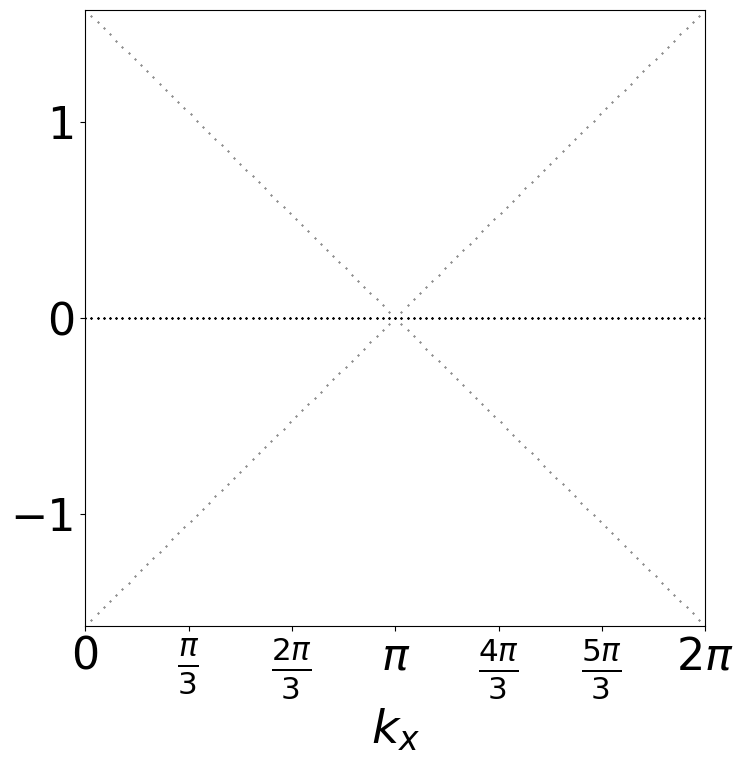

In [99]:
eigenvaluesss, eigenvectorsss = model_pest3_x.quasienergy_eigenstates(model_pest3_x.T, 100, 100, delta = 0, plot=True, pbc='x')

In [110]:
U = model_pest3.time_evolution_operator_pbc1(model_pest2.T, 100, 1, 1, 'xy', delta = 0)
print(U)

tensor([[ 1.0000e+00-2.8420e-15j,  6.6656e-16-3.6593e-08j],
        [-2.4018e-17-3.6593e-08j,  1.0000e+00-4.7067e-16j]], device='cuda:1',
       dtype=torch.complex128)


In [111]:
Ux = model_pest3_x.time_evolution_operator_pbc1(model_pest3_x.T, 100, 1, 1, 'xy', delta = 0)
print(Ux)

tensor([[ 1.0000e+00-1.9904e-23j,  6.9473e-28+4.8636e-12j,
         -4.0924e-12+7.4915e-12j, -2.3642e-23+0.0000e+00j,
         -1.2781e-23+1.9906e-23j,  0.0000e+00+4.8638e-12j,
         -9.6812e-35-6.2151e-35j,  5.4719e-20-2.1347e-19j],
        [ 1.0334e-34+4.8636e-12j,  1.0000e+00-1.4284e-16j,
         -2.8669e-16-1.8363e-23j,  0.0000e+00-1.1498e-34j,
          4.0927e-12+2.6279e-12j, -2.3658e-23+0.0000e+00j,
         -1.2779e-23+1.9902e-23j, -2.9644e-08-2.1022e-09j],
        [ 4.0928e-12+7.4919e-12j, -1.5490e-16+2.4124e-16j,
          1.0000e+00+3.2323e-16j, -1.4248e-08-9.1483e-09j,
          4.4703e-36-1.3944e-27j,  1.2680e-19-6.9327e-20j,
         -2.8669e-16+1.4256e-24j, -1.5396e-08+7.0461e-09j],
        [ 1.2684e-19+6.9279e-20j,  1.2866e-31+4.8541e-24j,
          1.4248e-08-9.1483e-09j,  1.0000e+00+3.5111e-16j,
          4.4496e-20+6.9299e-20j, -4.0896e-12+7.4931e-12j,
          1.4248e-08-9.1483e-09j, -1.5490e-16+2.4124e-16j],
        [-2.3659e-23+0.0000e+00j, -4.0927e-12+2.6280

In [100]:
print(eigenvaluesss[:,-1])

tensor([1.5708e+00, 1.5394e+00, 1.5080e+00, 1.4765e+00, 1.4451e+00, 1.4137e+00,
        1.3823e+00, 1.3509e+00, 1.3195e+00, 1.2881e+00, 1.2566e+00, 1.2252e+00,
        1.1938e+00, 1.1624e+00, 1.1310e+00, 1.0996e+00, 1.0681e+00, 1.0367e+00,
        1.0053e+00, 9.7389e-01, 9.4248e-01, 9.1106e-01, 8.7965e-01, 8.4823e-01,
        8.1681e-01, 7.8540e-01, 7.5398e-01, 7.2257e-01, 6.9115e-01, 6.5973e-01,
        6.2832e-01, 5.9690e-01, 5.6549e-01, 5.3407e-01, 5.0265e-01, 4.7124e-01,
        4.3982e-01, 4.0841e-01, 3.7699e-01, 3.4558e-01, 3.1416e-01, 2.8274e-01,
        2.5133e-01, 2.1991e-01, 1.8850e-01, 1.5708e-01, 1.2566e-01, 9.4248e-02,
        6.2832e-02, 3.1416e-02, 3.7470e-16, 3.1416e-02, 6.2832e-02, 9.4248e-02,
        1.2566e-01, 1.5708e-01, 1.8850e-01, 2.1991e-01, 2.5133e-01, 2.8274e-01,
        3.1416e-01, 3.4558e-01, 3.7699e-01, 4.0841e-01, 4.3982e-01, 4.7124e-01,
        5.0265e-01, 5.3407e-01, 5.6549e-01, 5.9690e-01, 6.2832e-01, 6.5973e-01,
        6.9115e-01, 7.2257e-01, 7.5398e-

In [106]:
print(eigenvectorsss[-1,:, 0])

tensor([ 2.0076e-18-1.7797e-18j, -3.6310e-17-1.6915e-17j,
         1.4837e-17-4.1212e-17j,  6.8813e-17-1.5769e-17j,
         4.1571e-16-8.8724e-17j, -1.7778e-17+6.5082e-17j,
         4.4045e-17+1.0616e-16j,  1.0000e+00+0.0000e+00j], device='cuda:1',
       dtype=torch.complex128)


In [157]:
aa = model_pest2.compare_H_eff_implementations(5, 100)

Average time for H_eff (loop version): 0.995432 seconds
Average time for H_eff1 (batch version): 0.989167 seconds
Speedup factor: 1.01x
Shapes match: True
Maximum absolute difference: 0.0
Results are close within tolerance 1e-08: True


In [294]:
kx, ky = model_pest2.get_k_values(2, 'xy')
print(kx)

tensor([0.0000, 6.2832], device='cuda:1')


In [212]:
U = model_pest2.time_evolution_operator_pbc1(2, 100, 1, 1, pbc= 'xy')
print(U)

tensor([[ 0.2345-0.5502j,  0.2477+0.7622j],
        [-0.2477+0.7622j,  0.2345+0.5502j]], device='cuda:1',
       dtype=torch.complex128)


In [285]:
deform_compare1 = model_pest2.deformed_U(model_pest2.T, 1, 100)

eigvals tensor([[[-0.5680+0.8230j, -0.5680-0.8230j],
         [-0.5680+0.8230j, -0.5680-0.8230j]],

        [[-0.5680+0.8230j, -0.5680-0.8230j],
         [-0.5680+0.8230j, -0.5680-0.8230j]]], device='cuda:1',
       dtype=torch.complex128)
tensor([[[-0.5680-0.8230j, -0.5680+0.8230j],
         [-0.5680-0.8230j, -0.5680+0.8230j]],

        [[-0.5680-0.8230j, -0.5680+0.8230j],
         [-0.5680-0.8230j, -0.5680+0.8230j]]], device='cuda:1',
       dtype=torch.complex128)


In [311]:
t = torch.tensor([0, 2],device="cuda:1")

In [319]:
deform_check1 = model_pest2.compute_deformed_U(2, 1, 100)
print(deform_check1[:,:,0])

tensor([[[[ 1.0000e+00+3.1397e-18j, -2.4613e-17-3.3983e-17j],
          [-2.4613e-17+2.5459e-17j,  1.0000e+00-1.1673e-18j]],

         [[ 1.0000e+00-3.6925e-18j,  2.6953e-17+1.0231e-16j],
          [ 2.6953e-17-1.0559e-16j,  1.0000e+00-2.5228e-19j]]],


        [[[ 1.0000e+00+3.1294e-18j, -6.9929e-17+6.3949e-17j],
          [-6.9929e-17-6.4223e-17j,  1.0000e+00-3.2108e-18j]],

         [[ 1.0000e+00-6.9050e-18j,  2.0970e-16+1.0938e-16j],
          [ 2.0970e-16-1.0599e-16j,  1.0000e+00+4.5972e-18j]]]],
       device='cuda:1', dtype=torch.complex128)


In [308]:
deform_check1 = model_pest2.compute_deformed_U(model_pest2.T, 1, 100)
print(deform_check1)

tensor([[[[ 1.0000e+00+4.9813e-17j, -1.3212e-16+1.4037e-16j],
          [-2.8903e-18+2.4048e-16j,  1.0000e+00-4.2919e-16j]],

         [[ 1.0000e+00-6.0819e-08j, -1.8713e-07+1.6102e-07j],
          [ 1.8713e-07+1.6102e-07j,  1.0000e+00+6.0819e-08j]]],


        [[[ 1.0000e+00+2.3808e-07j, -1.3628e-08-8.8194e-08j],
          [ 1.3628e-08-8.8194e-08j,  1.0000e+00-2.3808e-07j]],

         [[ 1.0000e+00+1.7726e-07j, -2.0076e-07+7.2826e-08j],
          [ 2.0076e-07+7.2826e-08j,  1.0000e+00-1.7726e-07j]]]],
       device='cuda:1', dtype=torch.complex128)


In [305]:
deform_check2 = model_pest2.compute_deformed_U(2, 1, 100, epsilonT=0)
print(deform_check2)

S_expanded shape: torch.Size([2, 2, 2, 2, 2])
exp_term_diag shape: torch.Size([2, 2, 2, 2, 2])
tensor([[[[[ 1.1668-0.1317j, -0.1668+0.1317j],
           [ 0.6438+0.1317j,  0.3562-0.1317j]],

          [[ 1.1668-0.1317j, -0.1668+0.1317j],
           [ 0.6438+0.1317j,  0.3562-0.1317j]]],


         [[[ 1.1668-0.1317j, -0.1668+0.1317j],
           [ 0.6438+0.1317j,  0.3562-0.1317j]],

          [[ 1.1668-0.1317j, -0.1668+0.1317j],
           [ 0.6438+0.1317j,  0.3562-0.1317j]]]],



        [[[[ 1.1668-0.1317j, -0.1668+0.1317j],
           [ 0.6438+0.1317j,  0.3562-0.1317j]],

          [[ 1.1668-0.1317j, -0.1668+0.1317j],
           [ 0.6438+0.1317j,  0.3562-0.1317j]]],


         [[[ 1.1668-0.1317j, -0.1668+0.1317j],
           [ 0.6438+0.1317j,  0.3562-0.1317j]],

          [[ 1.1668-0.1317j, -0.1668+0.1317j],
           [ 0.6438+0.1317j,  0.3562-0.1317j]]]]], device='cuda:1',
       dtype=torch.complex128)


In [296]:
deform_compare = model_pest2.time_evolution_operator_pbc1(2, 100, kx, ky, pbc='xy')
print(deform_compare)

tensor([[[[-0.5680+0.4304j,  0.2168+0.6672j],
          [-0.2168+0.6672j, -0.5680-0.4304j]],

         [[-0.5680+0.4304j,  0.2168+0.6672j],
          [-0.2168+0.6672j, -0.5680-0.4304j]]],


        [[[-0.5680+0.4304j,  0.2168+0.6672j],
          [-0.2168+0.6672j, -0.5680-0.4304j]],

         [[-0.5680+0.4304j,  0.2168+0.6672j],
          [-0.2168+0.6672j, -0.5680-0.4304j]]]], device='cuda:1',
       dtype=torch.complex128)


In [299]:
deform_check2 = model_pest2.compute_deformed_U(0.5, 1, 100, epsilonT=0)
print(deform_check2)

tensor([[[[0.5083+0.2346j, 0.5614-0.6094j],
          [0.6094-0.5614j, 0.2346+0.5083j]],

         [[0.5083+0.2346j, 0.5614-0.6094j],
          [0.6094-0.5614j, 0.2346+0.5083j]]],


        [[[0.5083+0.2346j, 0.5614-0.6094j],
          [0.6094-0.5614j, 0.2346+0.5083j]],

         [[0.5083+0.2346j, 0.5614-0.6094j],
          [0.6094-0.5614j, 0.2346+0.5083j]]]], device='cuda:1',
       dtype=torch.complex128)


In [274]:
model_pest2.H_eff(1, 100)

(tensor([[[[ 2.0101e-18+0.5687j,  2.8642e-01+0.8815j],
           [-2.8642e-01+0.8815j,  5.1694e-18-0.5687j]],
 
          [[ 1.0728e-17+0.5687j,  2.8642e-01+0.8815j],
           [-2.8642e-01+0.8815j, -9.4690e-18-0.5687j]]],
 
 
         [[[-8.3752e-19+0.5687j,  2.8642e-01+0.8815j],
           [-2.8642e-01+0.8815j,  3.9855e-18-0.5687j]],
 
          [[-1.1358e-17+0.5687j,  2.8642e-01+0.8815j],
           [-2.8642e-01+0.8815j,  1.8139e-18-0.5687j]]]], device='cuda:1',
        dtype=torch.complex128),
 tensor([[[0.+1.0874j, -0.-1.0874j],
          [0.+1.0874j, -0.-1.0874j]],
 
         [[0.+1.0874j, -0.-1.0874j],
          [0.+1.0874j, -0.-1.0874j]]], device='cuda:1', dtype=torch.complex128),
 tensor([[[[ 0.8726+0.0000j, -0.4645+0.1509j],
           [ 0.4645+0.1509j,  0.8726+0.0000j]],
 
          [[ 0.8726+0.0000j, -0.4645+0.1509j],
           [ 0.4645+0.1509j,  0.8726+0.0000j]]],
 
 
         [[[ 0.8726+0.0000j, -0.4645+0.1509j],
           [ 0.4645+0.1509j,  0.8726+0.0000j]],
 
      

In [271]:
_, val, wf = model_pest2.quasienergy_eigenstates(2, 1, 100, pbc='xy')

tensor([[[[-0.5680+0.4304j,  0.2168+0.6672j],
          [-0.2168+0.6672j, -0.5680-0.4304j]],

         [[-0.5680+0.4304j,  0.2168+0.6672j],
          [-0.2168+0.6672j, -0.5680-0.4304j]]],


        [[[-0.5680+0.4304j,  0.2168+0.6672j],
          [-0.2168+0.6672j, -0.5680-0.4304j]],

         [[-0.5680+0.4304j,  0.2168+0.6672j],
          [-0.2168+0.6672j, -0.5680-0.4304j]]]], device='cuda:1',
       dtype=torch.complex128)


In [357]:
U_0gap = model_pest2.compute_deformed_U(100, 100, 200, epsilonT=0)

In [358]:
w3_0gap1 = model_pest2.compute_winding_number(U_0gap)

In [359]:
print(w3_0gap1)

tensor(-0.0017, device='cuda:1', dtype=torch.float64)


In [360]:
U_pigap = model_pest2.compute_deformed_U(100, 100, 200)

In [361]:
w3_pigap1 = model_pest2.compute_winding_number(U_pigap)

In [362]:
print(w3_pigap1)

tensor(0.9565, device='cuda:1', dtype=torch.float64)


In [363]:
print(U_0gap.shape)

torch.Size([101, 101, 101, 4, 4])


In [364]:
U_pigap_afai = model_pest3.compute_deformed_U(100, 100, 200)

In [365]:
w3_pigap2 = model_pest3.compute_winding_number(U_pigap_afai)

In [366]:
print(w3_pigap2)

tensor(0.9756, device='cuda:1', dtype=torch.float64)


In [367]:
U_0gap_afai = model_pest3.compute_deformed_U(100, 100, 200, epsilonT=0)

In [368]:
w3_0gap2 = model_pest3.compute_winding_number(U_0gap_afai)

In [369]:
print(w3_0gap2)

tensor(0.9729, device='cuda:1', dtype=torch.float64)


In [370]:
U_0gap_trivial = model_pest.compute_deformed_U(100, 100, 200, epsilonT=0)

In [371]:
w3_0gap_trivial = model_pest.compute_winding_number(U_0gap_trivial)

In [372]:
print(w3_0gap_trivial)

tensor(-2.5003e-05, device='cuda:1', dtype=torch.float64)


In [373]:
U_pigap_trivial = model_pest.compute_deformed_U(100, 100, 200)

In [374]:
w3_pigap_trivial = model_pest.compute_winding_number(U_pigap_trivial)

In [375]:
print(w3_pigap_trivial)

tensor(-9.7291e-05, device='cuda:1', dtype=torch.float64)


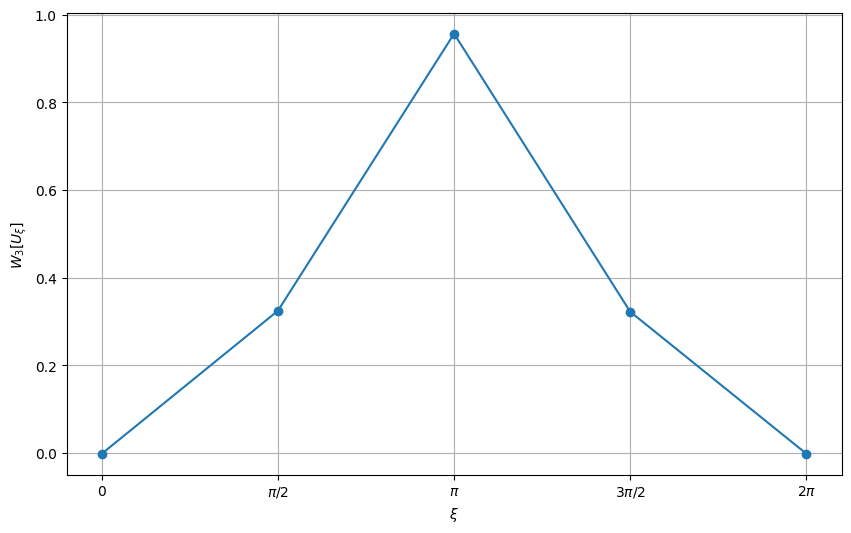

In [377]:
model_pest2.plot_W3_vs_xi(100, 100, 200, 5)

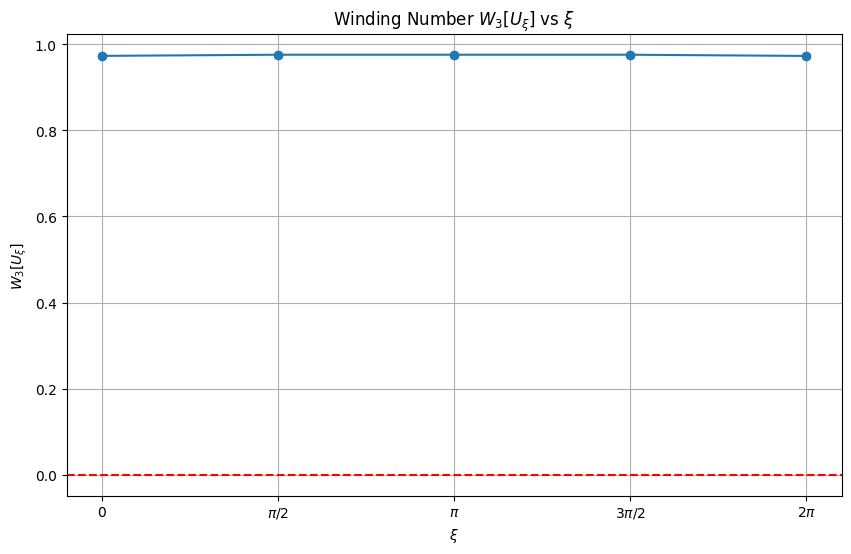

In [376]:
model_pest3.plot_W3_vs_xi(100, 100, 200, 5)

In [6]:
model_tbc1 = afai_parallel.tb_floquet_tbc_cuda(period, 1, hopping1, ny=6, nx=6, device='cuda:0')
model_tbc2 = afai_parallel.tb_floquet_tbc_cuda(period, 1, hopping2, ny=6, nx=6, device='cuda:0')
model_tbc3 = afai_parallel.tb_floquet_tbc_cuda(period, 1, hopping3, ny=6, nx=6, device='cuda:0')

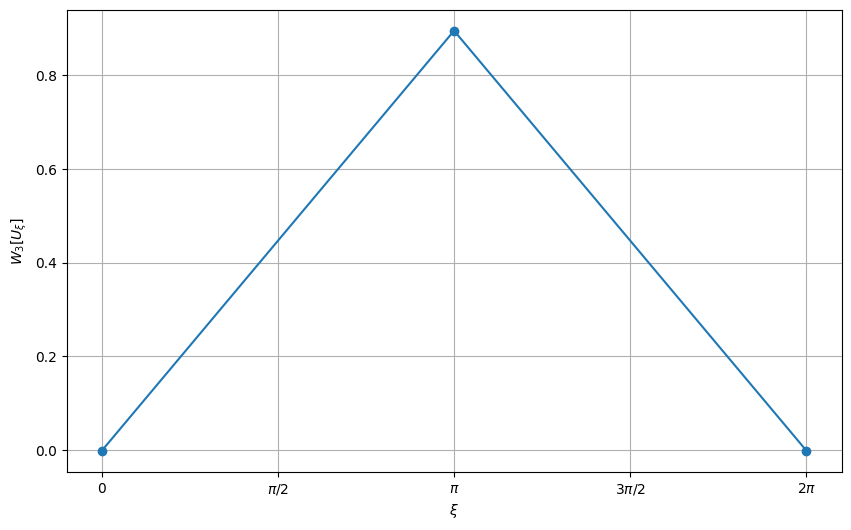

In [20]:
model_tbc2.plot_W3_vs_xi(26,40, 100, 3, vdT=0, fully_disorder=False)